In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats as st
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import folium
import nivapy
import seaborn as sn
import glob
import os
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import lmfit
import emcee
import corner
import statsmodels.api as sm
import statsmodels.formula.api as smf
from osgeo import gdal
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter('ignore')
sn.set_context('notebook')

# NOPE metals (continued)

## Background

The [previous notebook](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/nope_metals_2.ipynb) demonstrated that including atmospheric deposition substantially improves estimates of metal loads for Cd and Pb (compared to the previous approach).

Following on from this, Øyvind G suggested some reading material to better understand metal behaviours (see e-mail from Øyvind K received 13/11/2017 at 15:25). My notes based on these references are here:

C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet\NOPE\Metals\NOPE Metals Ideas.docx

For further details, see also the e-mail sent to Øyvind K, Øyvind G and John Rune on 21/11/2017 at 11:45. Øyvind G and I subsequently discussed things further via e-mail (22/11/2017), and this notebook develops these ideas further. 

The specific aims of this notebook are to:

 1. Spatially interpolate the moss data supplied by Øyvind G <br><br>
 
 2. Obtain spatially interpolated geochemical data from NGU's [Geokjemisk Atlas for Norge](https://www.ngu.no/emne/naturlige-bakgrunnsverdier) and reproject these to a common grid compatible with the moss datasets <br><br>
 
 3. Link the moss and geochemical datasets to the catchment data provided by Anders Finstad. Anders' dataset appears to include catchment boundaries for the watersheds upstream of the lakes sampled during the 1995 "1000 lakes" survey. For each catchment, I want to calculate average moss and geochemical concentrations using zonal statistics. In addition, Anders has already calculated catchment characteristics such as averge elevation, mean slope etc., which might help to estimate erosion and transport rates <br><br>
 
 4. Link Anders' catchment data to average runoff data (some combination of the annual NVE data, plus long-term averages from met.no?) <br><br>
 
 5. Link Anders' catchment data to point discharge data (e.g. from industry) previously stored in RESA2 <br><br>
 
 6. Link all of the datasets listed above to the water chemistry data in RESA2 from the "1000 lakes" survey <br><br>
 
 7. Explore some simple statistical models to see if we can predict metal concentrations as a function of: deposition (using mosses as a proxy), geology (using NGU's geochemistry data), catchment properties (from Anders' dataset) and other chemical parameters (primarily pH and TOC)
 
The first step is to establish the necessary database connections.

In [2]:
# Connect to Oracle
ora_eng = nivapy.da.connect(src='nivabase')

Username: ········
Password: ········
Connection successful.


In [3]:
# Connect to PostGIS
pg_eng = nivapy.da.connect(src='postgres')

Username: ········
Password: ········
Connection successful.


## 1. Define common co-ordinate reference system

For the zonal statistics calculations, all the datasets need spatially interpolating and re-projecting onto a common grid. For Norway at national scale, I have previously used an Albers Equal Area projection. The map below shows [Tissot indicatrices](https://en.wikipedia.org/wiki/Tissot%27s_indicatrix) for this projection, illustrating that the distortion over Norway is fairly minimal.

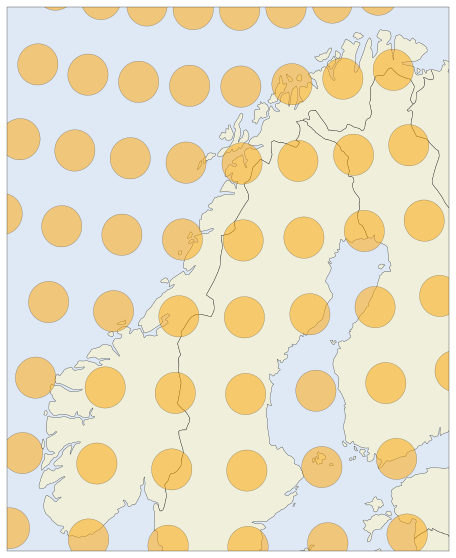

In [4]:
# Define co-ord system
crs = ccrs.AlbersEqualArea(central_longitude=15, 
                           central_latitude=65, 
                           false_easting=650000, 
                           false_northing=800000,
                           standard_parallels=(55, 75))

# Setup plot
fig = plt.figure(figsize=(10,10))
crs_ax = fig.add_subplot(1,1,1, projection=crs)
crs_ax.set_extent([0, 1300000, 0, 1600000], crs=crs) # Values in metres
                                                     # Originally found using Basemap

# Add Natural Earth data
# Land
land_50m = cfeature.NaturalEarthFeature(category='cultural',
                                        name='admin_0_countries', 
                                        scale='50m',
                                        edgecolor='black',
                                        facecolor=cfeature.COLORS['land'])
crs_ax.add_feature(land_50m)

# Sea
sea_50m = cfeature.NaturalEarthFeature(category='physical',
                                       name='ocean',
                                       scale='50m',
                                       edgecolor='none',
                                       facecolor=cfeature.COLORS['water'],
                                       alpha=0.3)
crs_ax.add_feature(sea_50m)

# Draw Tissot indicatrices to show distortion
lons = range(0, 30, 4)
lats = range(40, 80, 2)
crs_ax.tissot(rad_km=60000.0,     # Actually in metres. Fixed in v0.16?
              lons=lons, 
              lats=lats, 
              n_samples=100,      # Number of points for each circle
              facecolor='orange',
              edgecolor='black',
              alpha=0.5)

The code below creates a GeoTiff file with 1 km resolution covering exactly the area shown above. This grid will be used as a "snap raster" in all subsequent calculations.

In [5]:
# Set up 1 km grid
cell_size = 1000 # metres

# Extent
bbox = [round(i) for i in crs_ax.get_extent()]
xmin, xmax, ymin, ymax = bbox

# Rows and cols
cols = int(xmax - xmin) / cell_size 
rows = int(ymax - ymin) / cell_size
ones = np.ones(shape=(rows, cols))

# Write to GeoTiff
gtif_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
             r'\NOPE\Metals\GIS\Raster\norway_aea_1km_snap_ras.tif')
nivapy.spatial.array_to_gtiff(xmin, ymax, cell_size, gtif_path, ones, 
                              crs_ax.projection.proj4_init)

## 2. Spatially interpolate moss data

### 2.1. Visualise point data

The code below focuses on the 1990 moss survey. Ideally we should use the moss data from 1995 instead, as this is more directly comparable with the measurements from the 1995 lakes survey. However, Øyvind G does not have co-ordinate information for this dataset (see e-mail received 23/11/2017 at 10.00), so I'll work with the 1990 data for now and follow-up the 1995 data if the approach looks promising.

**Note:** Some of the concentration values in the raw data are less than 0. These are set to 0 in the code below.

In [6]:
# Read moss data
year = 1990
moss_xlsx = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
             r'\NOPE\Metals\Raw_Datasets\Moss_Surveys\moss_data_tidied.xlsx')
moss_df = pd.read_excel(moss_xlsx, sheetname='mosses_%s' % year)

# Set negative to zero
moss_df[moss_df<0] = 0

moss_df.head()

lat    lon     cr       ni      cu      zn     as     cd    pb
0  69.10  28.58   0.94   13.744   14.75  25.973  0.639  0.092  3.91
1  69.21  29.29   2.31   36.442   32.44  36.231  1.243  0.183  3.89
2  69.28  30.04   4.03  133.486  119.58  43.015  2.168  0.233  4.15
3  69.41  30.00  10.37   39.482   39.81  41.228  1.054  0.054  8.15
4  69.46  30.11   2.51   33.059   32.34  41.945  0.606  0.086  4.29

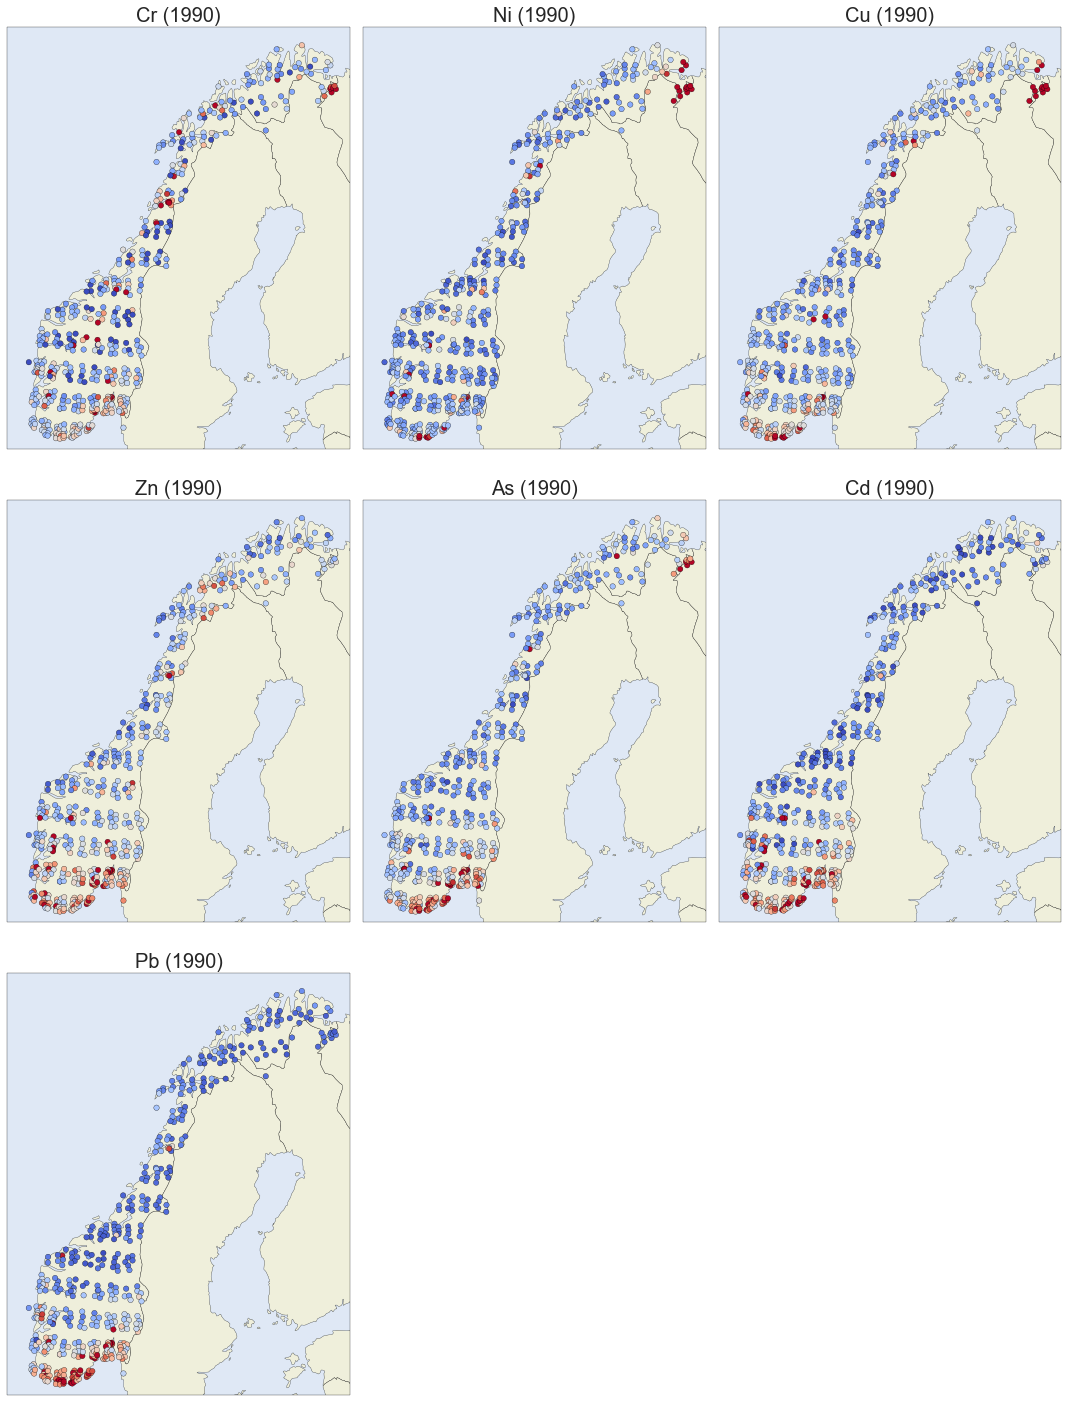

In [7]:
# Plot data
fig = plt.figure(figsize=(15, 20))

# Loop over pars
pars = [i for i in moss_df.columns if i not in ['lat', 'lon']]
for idx, par in enumerate(pars):
    # Get data
    df = moss_df[['lat', 'lon', par]].dropna(how='any')
    
    # Add subplot
    ax = fig.add_subplot(3, 3, idx+1, projection=crs)
    ax.set_extent(bbox, crs=crs)

    # Add geo data
    ax.add_feature(land_50m)
    ax.add_feature(sea_50m)

    # Set max value for colour ramp at 95th percentile
    # (otherwise compressed by outliers)
    pct = df[par].describe(percentiles=[0.95,]).ix['95%']
    
    # Add points using linear colour ramp from 0 to 95th percentile   
    ax.scatter(df['lon'].values, 
               df['lat'].values, 
               c=df[par].values, 
               cmap='coolwarm', 
               vmax=pct, 
               s=30, 
               zorder=5,
               edgecolors='k', 
               transform=ccrs.PlateCarree())
    
    ax.set_title('%s (%s)' % (par.capitalize(), year), fontsize=20)

plt.tight_layout()

These plots illustrate the relationships expected based on my earlier reading: Zn, As, Cd and Pb all show a similar pattern, which is strongly influenced by LRTAP (and some short-range air pollution near the Russian border); Cr, Ni and Cu are less obviously determined by LRTAP, although the short-range influence near Russia is still obvious.

### 2.2. Interpolation

The next step is to interpolate this point data onto the grid defined in section 1. The best option for this would probably be kriging, but as the point density is fairly high I should be able to achieve adequate results more easily using [IDW](https://en.wikipedia.org/wiki/Inverse_distance_weighting), cubic splines or bilinear interpolation. The code below applies all three methods for Cr and Pb (representing the two different "types" of metal behaviour) and saves the results as GeoTiffs. Based on these results, I can then pick one interpolation method and apply it to the rest of the data.

In [8]:
# Output folder
out_fold = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\NOPE\Metals\GIS\Raster\moss_data')

# Set up grid for interpolation
# Shift by (cell_size/2) s.t. values are estimated for the centre of each grid square
gridx = np.arange(xmin, xmax, cell_size) + (cell_size/2.)
gridy = np.arange(ymin, ymax, cell_size) + (cell_size/2.)

# Loop over pars
for par in ['cr', 'pb']: 
    # Get data
    df = moss_df[['lat', 'lon', par]].dropna(how='any')  

    # Map (long, lat) to projected (x, y) and reformat to syntax required 
    # by interp algorithms
    pts = crs.transform_points(src_crs=ccrs.PlateCarree(),
                               x=df['lon'].values, 
                               y=df['lat'].values)[:, :2]

    # Get values to interpolate
    vals = df[par].values

    # IDW interpolation
    idw = nivapy.spatial.interp_idw(pts, vals, gridx, gridy, n_near=8, p=2)
    idw[idw<0] = 0

    # Spline interpolation
    spl = nivapy.spatial.interp_cubic_spline(pts, vals, gridx, gridy)
    spl[spl<0] = 0

    # Bilinear interpolation
    bil = nivapy.spatial.interp_bilinear(pts, vals, gridx, gridy)
    bil[bil<0] = 0

    # Save output
    # IDW
    idw_path = os.path.join(out_fold, 'moss_%s_%s_idw_n8_p2.tif' % (year, par))
    nivapy.spatial.array_to_gtiff(xmin, ymax, cell_size, idw_path, idw, 
                                  crs_ax.projection.proj4_init)
    
    # Spline
    spl_path = os.path.join(out_fold, 'moss_%s_%s_spline.tif' % (year, par))
    nivapy.spatial.array_to_gtiff(xmin, ymax, cell_size, spl_path, spl, 
                                  crs_ax.projection.proj4_init)
    
    # Bilinear
    bil_path = os.path.join(out_fold, 'moss_%s_%s_bilinear.tif' % (year, par))
    nivapy.spatial.array_to_gtiff(xmin, ymax, cell_size, bil_path, bil, 
                                  crs_ax.projection.proj4_init)

The plots below compare these three different interpolation methods for Pb and Cr.

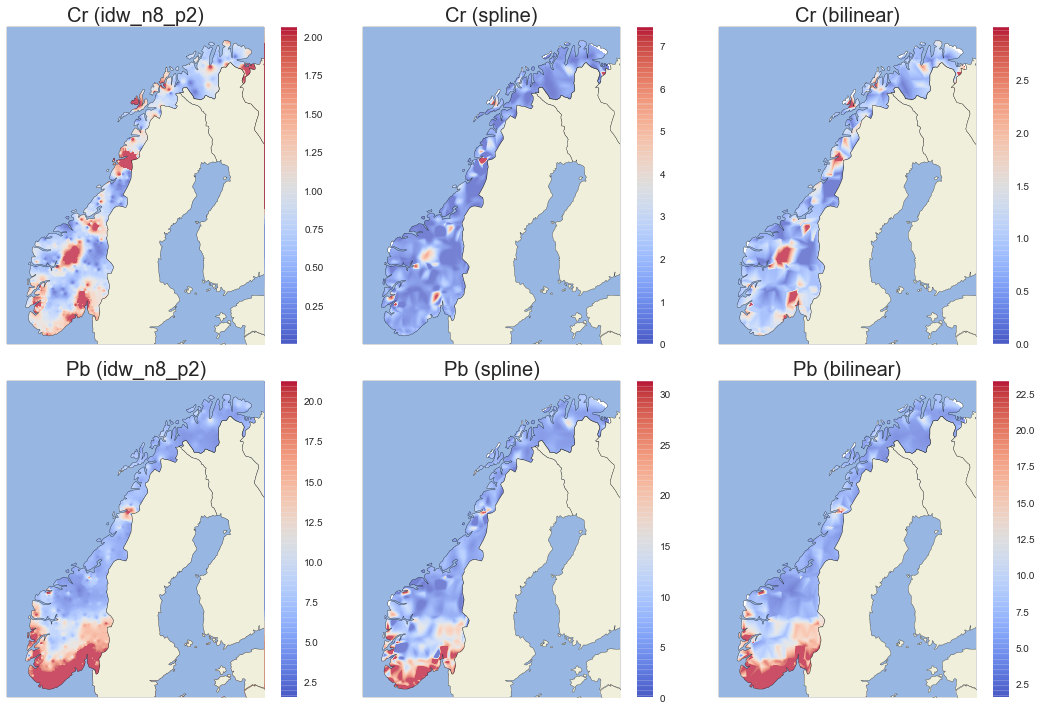

In [9]:
# Setup fig
fig = plt.figure(figsize=(15, 10))

# Adjust alpha sea
sea_50m = cfeature.NaturalEarthFeature(category='physical',
                                       name='ocean',
                                       scale='50m',
                                       edgecolor='none',
                                       facecolor=cfeature.COLORS['water'],
                                       alpha=1)

# Counter for incrementing plot numbers
cnt = 0

# Loop over data
for par in ['cr', 'pb']:
    for meth in ['idw_n8_p2', 'spline', 'bilinear']:
        cnt += 1
        
        # Read data
        gtiff_path = os.path.join(out_fold, 
                                  'moss_%s_%s_%s.tif' % (year, par, meth))
        data = nivapy.spatial.read_geotiff(gtiff_path, band=1)[0]
               
        # Plot
        ax = fig.add_subplot(2, 3, cnt, projection=crs)
        ax.set_extent(bbox, crs=crs)
        ax.set_title('%s (%s)' % (par.capitalize(), meth), fontsize=20)
        cax = ax.imshow(data, 
                        zorder=1,
                        extent=bbox,
                        cmap='coolwarm', 
                        alpha=0.7, 
                        interpolation='none',
                        vmax=np.nanpercentile(data, 95))
        
        # Add colourbar
        cbar = fig.colorbar(cax)
        
        # Get countries. Make Norway "hollow" so interpolated vaues
        # are visible. Make everywhere else opaque to mask wildly extrapolated
        # values
        shp = cartopy.io.shapereader.natural_earth(resolution='50m',
                                                   category='cultural',
                                                   name='admin_0_countries')
        reader = cartopy.io.shapereader.Reader(shp)
        countries = reader.records()

        # Loop over countries
        for country in countries:
            if country.attributes['NAME'] == 'Norway':
                # Transparent
                ax.add_geometries(country.geometry, 
                                  ccrs.PlateCarree(), # CRS of Natural Earth data
                                  facecolor='none', 
                                  edgecolor='black',
                                  zorder=5,)
            else:
                # Opaque
                ax.add_geometries(country.geometry, 
                                  ccrs.PlateCarree(), # CRS of Natural Earth data
                                  facecolor=cfeature.COLORS['land'],
                                  edgecolor='black',
                                  zorder=5)
        
        # Add sea
        ax.add_feature(sea_50m, zorder=4)

plt.tight_layout()

Looking at these maps, the results for IDW and bilinear interpolation are fairly similar, whereas the cubic splines method produces more extreme values (i.e. a more "spiky" surface). IDW tends to "clip off" peaks due to averaging, but overall the output looks pretty good to me. IDW also seems to do a better job of representing the high values close to the Russian border, so for the rest of this analysis I'll continue with IDW. 

The code below performs IDW interpolation for all parameters.

In [10]:
# Loop over pars
for par in pars: 
    # Get data
    df = moss_df[['lat', 'lon', par]].dropna(how='any')  

    # Map (long, lat) to projected (x, y) and reformat to syntax required 
    # by interp algorithms
    pts = crs.transform_points(src_crs=ccrs.PlateCarree(),
                               x=df['lon'].values, 
                               y=df['lat'].values)[:, :2]

    # Get values to interpolate
    vals = df[par].values

    # IDW interpolation
    idw = nivapy.spatial.interp_idw(pts, vals, gridx, gridy, n_near=8, p=2)

    # Save output
    idw_path = os.path.join(out_fold, 'moss_%s_%s_idw_n8_p2.tif' % (year, par))
    nivapy.spatial.array_to_gtiff(xmin, ymax, cell_size, idw_path, idw, 
                                  crs_ax.projection.proj4_init)

And here are the plots of the IDW-interpolated grids:

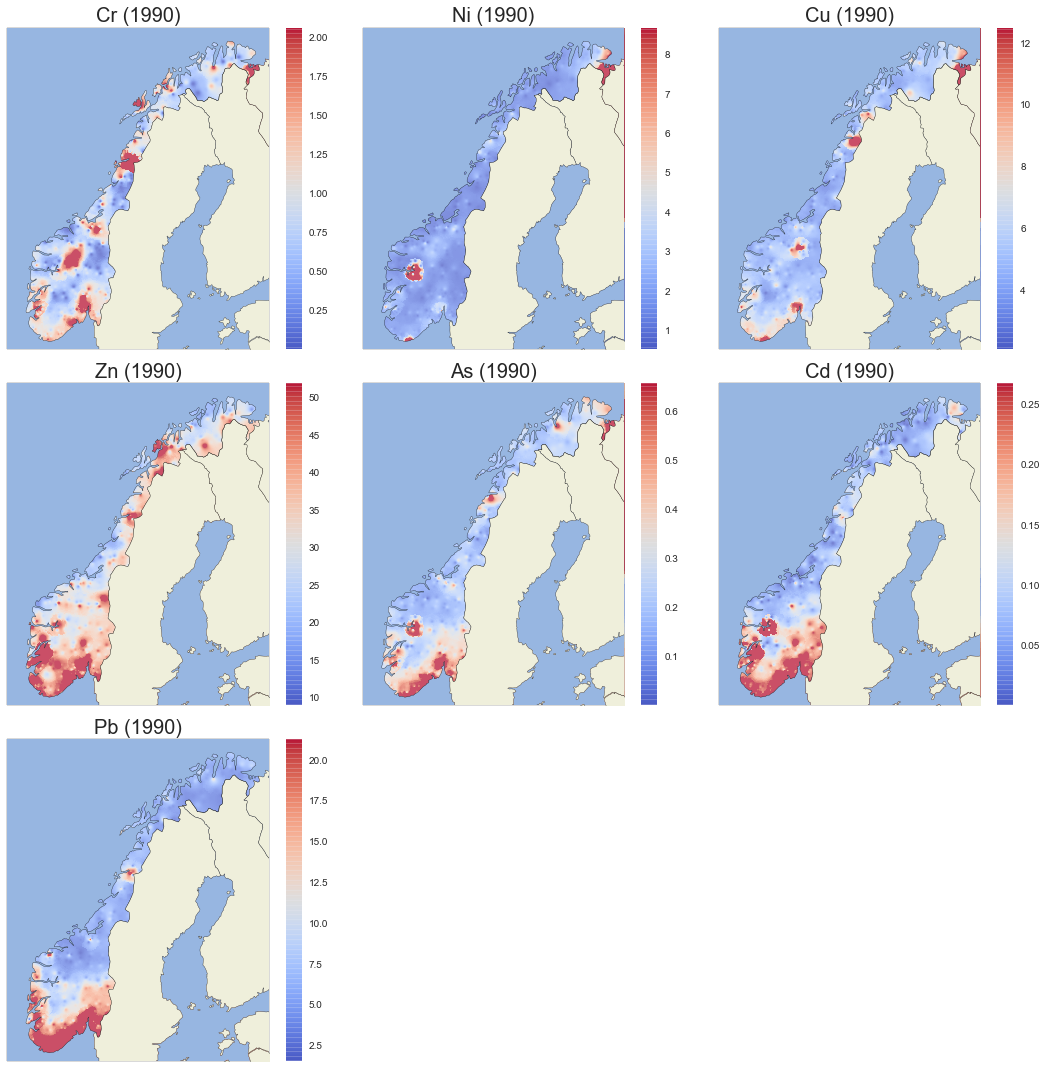

In [11]:
# Setup fig
fig = plt.figure(figsize=(15, 15))

# Loop over data
for idx, par in enumerate(pars):       
    # Read data
    gtiff_path = os.path.join(out_fold, 
                              'moss_%s_%s_idw_n8_p2.tif' % (year, par))
    data = nivapy.spatial.read_geotiff(gtiff_path, band=1)[0]

    # Plot
    ax = fig.add_subplot(3, 3, idx+1, projection=crs)
    ax.set_extent(bbox, crs=crs)
    ax.set_title('%s (%s)' % (par.capitalize(), year), fontsize=20)
    cax = ax.imshow(data, 
                    zorder=1,
                    extent=bbox,
                    cmap='coolwarm', 
                    alpha=0.7, 
                    interpolation='none',
                    vmax=np.nanpercentile(data, 95))

    # Add colourbar
    cbar = fig.colorbar(cax)

    # Get countries. Make Norway "hollow" so interpolated vaues
    # are visible. Make everywhere else opaque to mask wildly extrapolated
    # values
    shp = cartopy.io.shapereader.natural_earth(resolution='50m',
                                               category='cultural',
                                               name='admin_0_countries')
    reader = cartopy.io.shapereader.Reader(shp)
    countries = reader.records()

    # Loop over records
    for country in countries:
        if country.attributes['NAME'] == 'Norway':
            # Transparent
            ax.add_geometries(country.geometry, 
                              ccrs.PlateCarree(), # CRS of Natural Earth data
                              facecolor='none', 
                              edgecolor='black',
                              zorder=5,)
        else:
            # Opaque
            ax.add_geometries(country.geometry, 
                              ccrs.PlateCarree(), # CRS of Natural Earth data
                              facecolor=cfeature.COLORS['land'],
                              edgecolor='black',
                              zorder=5)

    # Add sea
    ax.add_feature(sea_50m, zorder=4)

plt.tight_layout()

## 3. Spatially interpolate geochemical data

Tor Erik Finne at NGU has kindly supplied the point data underpinning the [Geokjemisk Atlas for Norge](https://www.ngu.no/emne/naturlige-bakgrunnsverdier) (see e-mail received 23/11/2017 at 13.57). The geochemical workflow is similar to that for the moss data: I first want to visualise the point data to get an idea of its distribution, then interpolate it onto a standard grid for further analysis.

Some key points to note regarding the geochemical data:

 * Values are available from two different analysis procedures: extract using nitric acid and "total" content estimated using X-ray fluorescence (XRF). The XRF dataset is probably preferable, but unfortunately does not include As. At present, I'm mostly interested in having values that are *proportional to* metal concentrations, rather than accurate absolute measurements. I will therefore use the nitric acid data in the analysis below <br><br>
 
 * However, I would also like to check that my interpolation procedure is reasonable, and the only data I have to compare against is the image for Cr from the [NGU website](https://www.ngu.no/emne/naturlige-bakgrunnsverdier), which is based on the "total" XRF data. I will therefore first interpolate the total XRF Cr data to see whether I get a comparable image, and if everything looks OK I'll apply the same approach to the nitric acid data <br><br>
 
 * Most of the samples (612 out of 690) come from 10 cm depth. The remainder are "integrated" samples covering a range of depth intervals. At least initially, I will use all the available data, but it may be necessary to revise this if nearby values from different depths cause problems for the interpolation algorithm <br><br>
 
 * All of the measurements were taken during 1984 and 1985 <br><br>
 
 * All units are given as **parts per million (ppm)**. It is not specified whether this is by mass or by volume, but the example map for Cr [here](https://www.ngu.no/emne/naturlige-bakgrunnsverdier) gives the units as mg/kg (i.e. ppm by mass). I will therefore assume that all values in the spreadsheet are also mg/kg.

### 3.1. Compare Cr data to figure from Geochemical Atlas

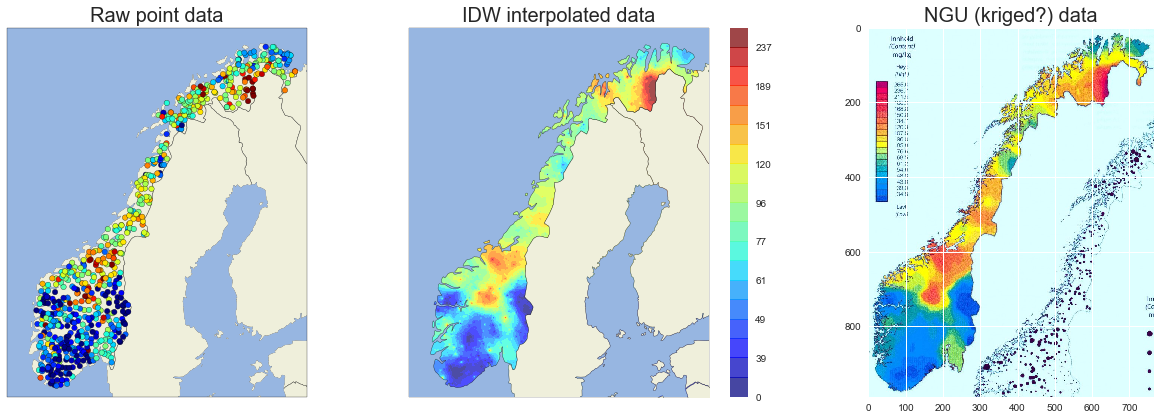

In [12]:
# Read Cr data
geo_xlsx = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\NOPE\Metals\Raw_Datasets\Geochemical_Surveys\ngu_geochem_tidied.xlsx')
df = pd.read_excel(geo_xlsx, sheetname='total_xrf')
df = df[['lat', 'lon', 'cr']].dropna(how='any')

# The single value of 4484 mg/kg is a HUGE outlier (see below)
# Remove
df = df.query('cr < 1000')

# Map (long, lat) to projected (x, y) 
pts = crs.transform_points(src_crs=ccrs.PlateCarree(),
                           x=df['lon'].values, 
                           y=df['lat'].values)[:, :2]

# Get values to interpolate
vals = df['cr'].values

# Interpolate
idw = nivapy.spatial.interp_idw(pts, vals, gridx, gridy, n_near=20, p=1)

# Plot
fig = plt.figure(figsize=(18, 6))

# Construct a colourmap roughly comparable to the one used by NGU
# NB: my matching here is only partially successful
base = plt.cm.get_cmap('jet')
bnds = np.array([0,35,39,44,49,55,61,69,    # From NGU map
                 77,86,96,108,120,135,151,
                 169,189,212,237,265])
norm = matplotlib.colors.BoundaryNorm(bnds, base.N)

# 1. Point data
ax = fig.add_subplot(1, 3, 1, projection=crs)
ax.set_extent(bbox, crs=crs)

# Add geo data
ax.add_feature(land_50m)
ax.add_feature(sea_50m)

# Add points  
ax.scatter(df['lon'].values, 
           df['lat'].values, 
           c=df['cr'].values, 
           cmap='jet',        
           norm=norm,           
           s=30, 
           zorder=5,
           edgecolors='k', 
           transform=ccrs.PlateCarree())
ax.set_title('Raw point data', fontsize=20)

# 2. Interpolated data
ax = fig.add_subplot(1, 3, 2, projection=crs)
ax.set_extent(bbox, crs=crs)
ax.set_title('IDW interpolated data', fontsize=20)
cax = ax.imshow(idw, 
                zorder=1,
                extent=bbox,
                cmap='jet',           
                alpha=0.7, 
                interpolation='none',
                norm=norm)             
cbar = fig.colorbar(cax)

# Get country data 
shp = cartopy.io.shapereader.natural_earth(resolution='50m',
                                           category='cultural',
                                           name='admin_0_countries')
reader = cartopy.io.shapereader.Reader(shp)
countries = reader.records()

# Loop over countries
for country in countries:
    if country.attributes['NAME'] == 'Norway':
        # Transparent
        ax.add_geometries(country.geometry, 
                          ccrs.PlateCarree(), # CRS of Natural Earth data
                          facecolor='none', 
                          edgecolor='black',
                          zorder=5,)
    else:
        # Opaque
        ax.add_geometries(country.geometry, 
                          ccrs.PlateCarree(), # CRS of Natural Earth data
                          facecolor=cfeature.COLORS['land'],
                          edgecolor='black',
                          zorder=5)

# Add sea
ax.add_feature(sea_50m, zorder=4)

# 3. Add NGU image (NB: not properly georeferenced!)
ax = fig.add_subplot(1, 3, 3)
im_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\Metals\Raw_Datasets\Geochemical_Surveys\Geochem_Atlas_Cr_Example.jpg')
img=mpimg.imread(im_path)
ax.imshow(img)
ax.set_title('NGU (kriged?) data', fontsize=20)

plt.tight_layout()

Based on these maps, I'd say the interpolation is working pretty well. The main differences between my IDW version and the one published in the Geochemical Atlas are explained by the choices of colour scheme: on the NGU map, bright yellow corresponds to values around 85 mg/kg, whereas on my version it's more like 120 mg/kg. I could spend longer attempting to match the colour schemes, but I don't think it's necessary - these results seem reasonable to me.

Note, however, that in the code above I've changed the p-exponent for the IDW algorithm to 1 (instead of 2), and also increased the number of nearest neighbours from 8 (for the mosses) to 20, as these values give results that are more comparable to the NGU map. The p-exponent determines how quickly spatial weights decline with distance: a value of 1 means the weights are proportional to $\frac{1}{d}$, whereas a value of 2 corresponds to $\frac{1}{d^2}$. Using `p=1` and `n_near=20` therefore results in more spatial averaging, and this seems to work well for the geochemical data.

Note also that there is a single point in the Cr dataset with a value of 4484 mg/kg. The next biggest value is 484 mg/kg, so a value of >4000 is a pretty huge outlier. I assume there's something wrong with this measurement (especially since the nitric acid extract data does not include any such outliers), so I have removed it from consideration in the code above.

In the nitric acid data, there is a similar outlier for Ni (max 1100 mg/kg; next largest value 282 mg/kg), which I will also remove from consideration (see code below). 

### 3.1. Visualise point data

Using the results above as a guide, I can now process the **nitric acid extract** data for all metals.

In [13]:
# Read geo data
geo_xlsx = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\NOPE\Metals\Raw_Datasets\Geochemical_Surveys\ngu_geochem_tidied.xlsx')
geo_df = pd.read_excel(geo_xlsx, sheetname='nitric_acid')

# Delete unnecessary cols
del geo_df['date'], geo_df['from_depth'], geo_df['to_depth']

geo_df.head()

lon        lat     cr     ni    cu      zn    as    pb
0   9.705842  62.880829  87.09  38.99  14.0   33.93  1.62  14.0
1  10.897466  60.035979  31.82  21.53  13.0  101.50  3.12  14.0
2  11.077467  60.427157  23.75   9.42  12.0   35.03  1.00  18.0
3   5.827683  61.205022  10.63   8.20  14.0   46.03  0.97  20.0
4   8.396488  61.747305  54.09  14.30  57.0   18.17  0.56   5.0

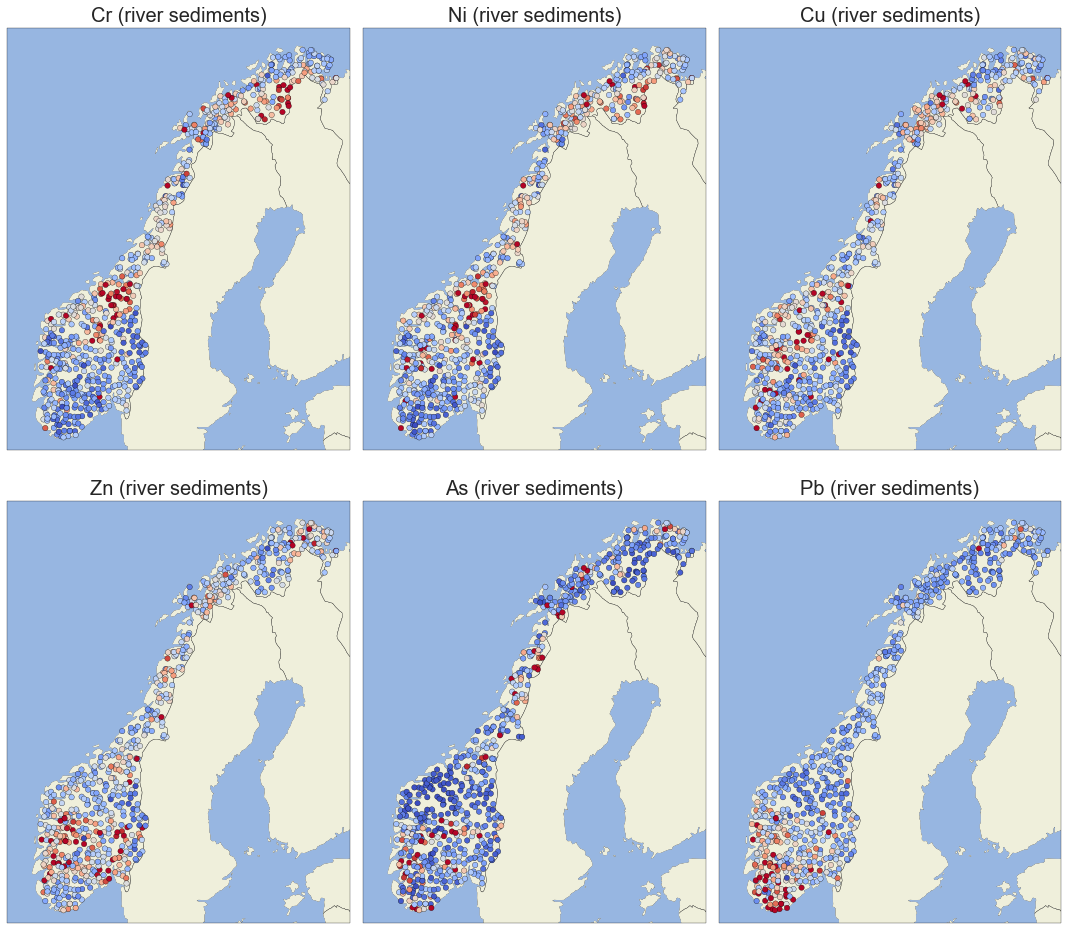

In [14]:
# Plot data
fig = plt.figure(figsize=(15, 20))

# Loop over pars
pars = [i for i in geo_df.columns if i not in ['lat', 'lon']]
for idx, par in enumerate(pars):
    # Get data
    df = geo_df[['lat', 'lon', par]].dropna(how='any')
    
    # Remove outlier for Ni
    if par == 'ni':
        df = df.query('ni < 1000')
    
    # Add subplot
    ax = fig.add_subplot(3, 3, idx+1, projection=crs)
    ax.set_extent(bbox, crs=crs)

    # Add geo data
    ax.add_feature(land_50m)
    ax.add_feature(sea_50m)

    # Set max value for colour ramp at 95th percentile
    # (otherwise compressed by outliers)
    pct = df[par].describe(percentiles=[0.95,]).ix['95%']
    
    # Add points using linear colour ramp from 0 to 95th percentile   
    ax.scatter(df['lon'].values, 
               df['lat'].values, 
               c=df[par].values, 
               cmap='coolwarm', 
               vmax=pct, 
               s=30, 
               zorder=5,
               edgecolors='k', 
               transform=ccrs.PlateCarree())
    
    ax.set_title('%s (river sediments)' % par.capitalize(), fontsize=20)

plt.tight_layout()

### 3.2. Interpolation

The code below uses IDW interpolation to convert the geochemical point data to a regular grid. Based on the tests above, I'm using `p=1` and `n_near=20` for the IDW parameters.

In [15]:
# Output folder
out_fold = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\NOPE\Metals\GIS\Raster\geochem_data')

# Loop over pars
for par in pars: 
    # Get data
    df = geo_df[['lat', 'lon', par]].dropna(how='any')  

    # Remove outlier for Ni
    if par == 'ni':
        df = df.query('ni < 1000')
        
    # Map (long, lat) to projected (x, y)
    pts = crs.transform_points(src_crs=ccrs.PlateCarree(),
                               x=df['lon'].values, 
                               y=df['lat'].values)[:, :2]

    # Get values to interpolate
    vals = df[par].values

    # IDW interpolation
    idw = nivapy.spatial.interp_idw(pts, vals, gridx, gridy, n_near=20, p=1)

    # Save output
    idw_path = os.path.join(out_fold, 'geochem_%s_idw_n20_p1.tif' % par)
    nivapy.spatial.array_to_gtiff(xmin, ymax, cell_size, idw_path, idw, 
                                  crs_ax.projection.proj4_init)

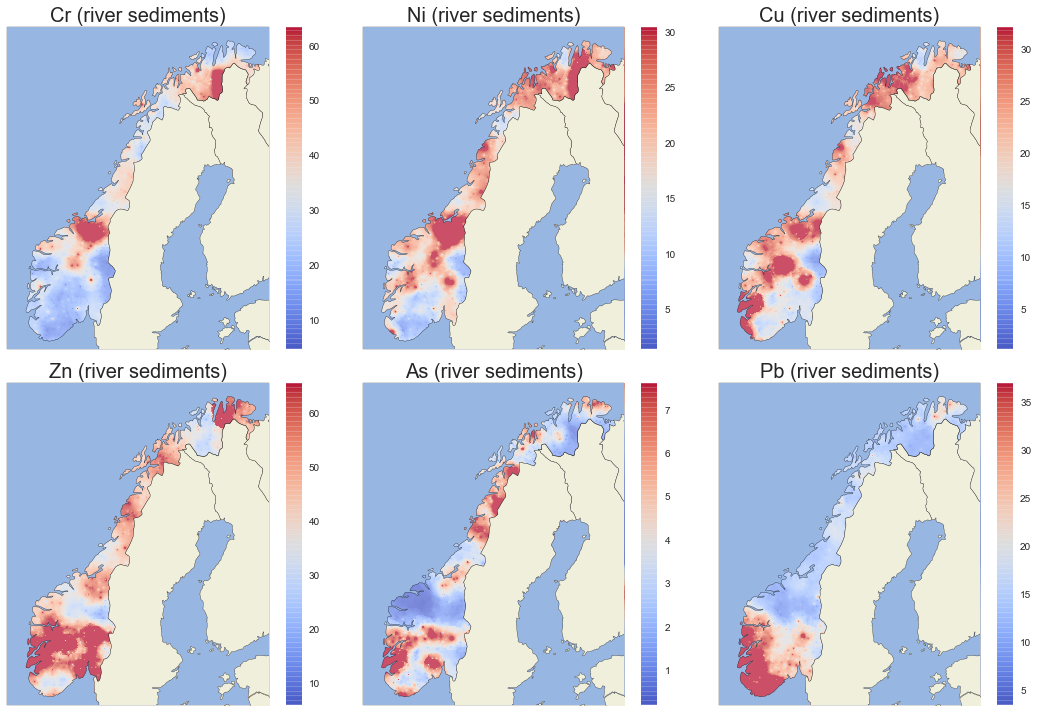

In [16]:
# Setup fig
fig = plt.figure(figsize=(15, 15))

# Loop over data
for idx, par in enumerate(pars):       
    # Read data
    gtiff_path = os.path.join(out_fold, 
                              'geochem_%s_idw_n20_p1.tif' % par)
    data = nivapy.spatial.read_geotiff(gtiff_path, band=1)[0]

    # Plot
    ax = fig.add_subplot(3, 3, idx+1, projection=crs)
    ax.set_extent(bbox, crs=crs)
    ax.set_title('%s (river sediments)' % par.capitalize(), fontsize=20)
    cax = ax.imshow(data, 
                    zorder=1,
                    extent=bbox,
                    cmap='coolwarm', 
                    alpha=0.7, 
                    interpolation='none',
                    vmax=np.nanpercentile(data, 95))

    # Add colourbar
    cbar = fig.colorbar(cax)

    # Get countries
    shp = cartopy.io.shapereader.natural_earth(resolution='50m',
                                               category='cultural',
                                               name='admin_0_countries')
    reader = cartopy.io.shapereader.Reader(shp)
    countries = reader.records()

    # Loop over records
    for country in countries:
        if country.attributes['NAME'] == 'Norway':
            # Transparent
            ax.add_geometries(country.geometry, 
                              ccrs.PlateCarree(), # CRS of Natural Earth data
                              facecolor='none', 
                              edgecolor='black',
                              zorder=5,)
        else:
            # Opaque
            ax.add_geometries(country.geometry, 
                              ccrs.PlateCarree(), # CRS of Natural Earth data
                              facecolor=cfeature.COLORS['land'],
                              edgecolor='black',
                              zorder=5)

    # Add sea
    ax.add_feature(sea_50m, zorder=4)

plt.tight_layout()

## 4. Zonal statistics

The next step is to get the catchment boundaries supplied by Anders Finstad and caclulate summary statistics for each catchment based on the interpolated moss and geochemical datasets.

### 4.1. Get catchment data

The data supplied by Anders is quite complex, and I have previously added it to my local PostGIS database. For the analysis here, I'm only interested in a small subset of the available catchment properties. The code below extracts the data, reprojects it, and save it as a shapefile for further processing.

In [17]:
# Extract catchment data 
sql = ("SELECT geom, "
       "  lake_id, "
       "  lake_name AS name, "
       "  altitude_average AS alt_avg, "
       "  slope_average AS slp_avg, "
       "  slope_var AS slp_var, "
       "  catchment_area_km2 AS area_km2 "
       "FROM niva_work.nope_metals.ecco_biwa "
       "WHERE nation = 'Norway'")
crs = {'init': 'epsg:25833'} # UTM Zone 33N ETRS89
cat_gdf = gpd.GeoDataFrame.from_postgis(sql, geom_col='geom', 
                                        crs=crs, con=pg_eng)

# Reproject to common crs
cat_gdf = cat_gdf.to_crs(crs_ax.projection.proj4_init)

# Save
shp_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\Metals\GIS\Vector\lakes_1k_catchments.shp')
cat_gdf.to_file(shp_path)

print 'Total number of catchments:', len(cat_gdf)
cat_gdf.head()

Total number of catchments: 990


geom   lake_id  \
0  (POLYGON ((462822.5019760047 155364.9632065317...   118-1-7   
1  (POLYGON ((441389.0901590431 229329.4787081783...   227-2-1   
2  (POLYGON ((158124.9434222006 380704.3963597477...  1266-2-1   
3  (POLYGON ((217211.1767291659 223269.2287373355...   834-4-7   
4  (POLYGON ((526006.6282515525 695245.8187160539...  1736-1-2   

             name      alt_avg    slp_avg     slp_var  area_km2  
0          HOH113   117.429493   1.283039    2.518281    0.4296  
1            Heia   220.582426   6.982528   41.813836   17.5300  
2  Svadfjellvatni   869.364951  15.021529  142.861185    1.4942  
3     Holmavatnet  1158.677692   8.045503   77.777198   54.2214  
4       Fiskløysa   647.525184   7.544434   73.569782    0.2438

### 4.2. Calculate statistics

I have previously written code for calculating zonal statistics that is more flexible (and much faster) than the algorithms available in ArcGIS. In particular, unlike ArcGIS, the zonal statistics code I have recently added to NivaPy is capable of dealing with overlapping polygons, which is a requirement for the work here. The downside of my code is that cells are only assigned to catchments when the cell centre falls within the catchment boundary, and as we're using a 1 km resolution grid it is possible  for very small catchments (<< 1 km) to end up not being associated with any raster cells. To get around this problem, the code below resamples each GeoFiff to 250 m resolution using the `nearest neighbour` technique. This results in an 16-fold increase in file sizes, so it's not very computationally efficient, but for this particular dataset this shouldn't be a problem.

In [18]:
# GeoTiff folders
moss_fold = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
             r'\NOPE\Metals\GIS\Raster\moss_data')

geo_fold = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\NOPE\Metals\GIS\Raster\geochem_data')

# Temporary 250 m raster
temp_ras = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\NOPE\Metals\GIS\Raster\temp_250m.tif')

# Container for data
df_list = []

# Loop over moss data
pars = [i for i in moss_df.columns if i not in ['lat', 'lon']]
for par in pars:
    # Get path to raster
    ras_path = os.path.join(moss_fold, 'moss_%s_%s_idw_n8_p2.tif' % (year, par))
    
    # Re-save raster at 250 m res
    val_ras = nivapy.spatial.read_geotiff(ras_path, band=1)[0]
    val_ras = nivapy.spatial.rebin_array(val_ras, 4) # 1000 m to 250 m
    nivapy.spatial.array_to_gtiff(xmin, ymax, 250, temp_ras, val_ras, 
                                  crs_ax.projection.proj4_init)
    
    # Calc stats
    stat_df = nivapy.spatial.zonal_stats(shp_path, temp_ras)
    
    # Set index
    stat_df.index = stat_df['fid']
    del stat_df['fid']
    
    # Get just mean and std. dev.
    stat_df = stat_df[['mean', 'std']]
    stat_df.columns = ['moss_%s_%s' % (par, i) for i in stat_df.columns]
    
    # Add to output
    df_list.append(stat_df)

# Loop over geochem data
pars = [i for i in geo_df.columns if i not in ['lat', 'lon']]
for par in pars:
    # Get path to raster
    ras_path = os.path.join(geo_fold, 'geochem_%s_idw_n20_p1.tif' % par)

    # Re-save raster at 250 m res
    val_ras = nivapy.spatial.read_geotiff(ras_path, band=1)[0]
    val_ras = nivapy.spatial.rebin_array(val_ras, 4) # 1000 m to 250 m
    nivapy.spatial.array_to_gtiff(xmin, ymax, 250, temp_ras, val_ras, 
                                  crs_ax.projection.proj4_init)
    
    # Calc stats
    stat_df = nivapy.spatial.zonal_stats(shp_path, temp_ras)
    
    # Set index
    stat_df.index = stat_df['fid']
    del stat_df['fid']
    
    # Get just mean and std. dev.
    stat_df = stat_df[['mean', 'std']]
    stat_df.columns = ['geo_%s_%s' % (par, i) for i in stat_df.columns]
    
    # Add to output
    df_list.append(stat_df)

# Delete temp_ras
os.remove(temp_ras)

# Merge into a single dataset
stat_df = pd.concat(df_list, axis=1)

# Convert catchments to plain df
cols = [i for i in cat_gdf.columns if i != 'geom']
cat_df = pd.DataFrame(cat_gdf[cols])

# Join to stats
cat_df = pd.merge(cat_df, stat_df, how='left',
                  left_index=True, right_index=True)

cat_df.head()

lake_id            name      alt_avg    slp_avg     slp_var  area_km2  \
0   118-1-7          HOH113   117.429493   1.283039    2.518281    0.4296   
1   227-2-1            Heia   220.582426   6.982528   41.813836   17.5300   
2  1266-2-1  Svadfjellvatni   869.364951  15.021529  142.861185    1.4942   
3   834-4-7     Holmavatnet  1158.677692   8.045503   77.777198   54.2214   
4  1736-1-2       Fiskløysa   647.525184   7.544434   73.569782    0.2438   

   moss_cr_mean  moss_cr_std  moss_ni_mean  moss_ni_std     ...      \
0      1.313870     0.007830      1.817870     0.013648     ...       
1      1.217668     0.014041      1.289349     0.022165     ...       
2      0.514820     0.005723      1.222819     0.016574     ...       
3      0.493505     0.042375      1.392313     0.022372     ...       
4      0.506990     0.000127      1.184942     0.001080     ...       

   geo_ni_mean  geo_ni_std  geo_cu_mean  geo_cu_std  geo_zn_mean  geo_zn_std  \
0    19.463951    0.015790    14.791145    0.029488    67.220087    0.092955   
1    19.323571    0.078072    15.004085    0.289037    66.771715    0.867881   
2    14.037326    0.375102    18.981607    0.370123    51.090220    0.548855   
3    13.266872    0.298734    33.723264    1.090034    82.994366    2.184810   
4    19.763939    0.015199    15.443104    0.002450    40.332142    0.025757   

   geo_as_mean  geo_as_std  geo_pb_mean  geo_pb_std  
0     3.380326    0.001727    26.131042    0.048094  
1     2.667793    0.036659    21.318825    0.090940  
2     5.221988    0.211180    37.465154    0.423776  
3     7.304407    0.237982    45.404882    1.360928  
4     4.717668    0.014869    13.962950    0.000220  

[5 rows x 32 columns]

## 5. Estimate annual runoff for each catchment

Annual runoff is important in determining pollutant concentrations, but it is not recorded in RESA for the lakes surveyed in 1995, nor is it included in Anders' catchment dataset.

I have previously used NVE modelled discharge for Norway's main catchments combined with long-term average runoff for each regine catchment to estimate regine-level annual runoff for each year from 1990 to 2016 (see [here](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/nope_model_inputs.ipynb#2.-Discharge) for details). My best option for estimating annual runoff in each of the lake catchments is therefore to use these regine level summaries.

The code below reads the regine level data, joins it to a regine shapefile and then rasterises it to 250 m resolution using the extent and co-ordinate reference system defined above. This is then used in a further zonal statistics operation to estimate the average runoff (and standard deviation) in each lake catchment.

### 5.1. Rasterise regine data

In [19]:
# Update year to 1995 (only using 1990 temporarily for mosses)
year = 1995 

# Read annual runoff for each regine for year of interest
print 'Reading runoff data...'
ro_fold = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\NOPE_Annual_Inputs')
ro_path = os.path.join(ro_fold, 'nope_input_data_%s.csv' % year)
ro_df = pd.read_csv(ro_path)
ro_df = ro_df[['regine', 'runoff_mm/yr']]
ro_df.columns = ['regine', 'ro_mm/yr']

# Read regine shapefile
print 'Reading regine shapefile...'
reg_shp = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\Data\gis\shapefiles\RegMinsteF.shp')
reg_gdf = gpd.read_file(reg_shp)
reg_gdf = reg_gdf[['geometry', 'VASSDRAGNR']]
reg_gdf.columns = ['geometry', 'regine']

# Reproject to common crs
reg_gdf = reg_gdf.to_crs(crs_ax.projection.proj4_init)

# Join runoff
reg_gdf = reg_gdf.merge(ro_df, how='left', on='regine')

# Write to shp
print 'Writing joined shapefile...'
reg_shp = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\Metals\GIS\Vector\regine_runoff_%s.shp' % year)
reg_gdf.to_file(reg_shp)

# Convert snap raster to 250 m resolution
print 'Creating 250 m snap raster...'
path_1k = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\Metals\GIS\Raster\norway_aea_1km_snap_ras.tif')
snap_1k = nivapy.spatial.read_geotiff(path_1k, band=1)[0]
snap_250m = nivapy.spatial.rebin_array(snap_1k, 4) # 1000 m to 250 m

# Save
path_250m = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
             r'\NOPE\Metals\GIS\Raster\norway_aea_250m_snap_ras.tif')
nivapy.spatial.array_to_gtiff(xmin, ymax, 250, path_250m, snap_250m, 
                              crs_ax.projection.proj4_init)

# Convert regine shp to raster
print 'Rasterising regine runoff data...'
reg_ras = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\Metals\GIS\Raster\regine_runoff_%s.tif' % year)
nivapy.spatial.shp_to_ras(reg_shp, reg_ras, path_250m, 'ro_mm/yr', -999, 
                          gdal.GDT_Float32, fmt='GTiff')

print 'Done.'

Reading runoff data...
Reading regine shapefile...
Writing joined shapefile...
Creating 250 m snap raster...
Rasterising regine runoff data...
Done.


### 5.2. Plot runoff grid

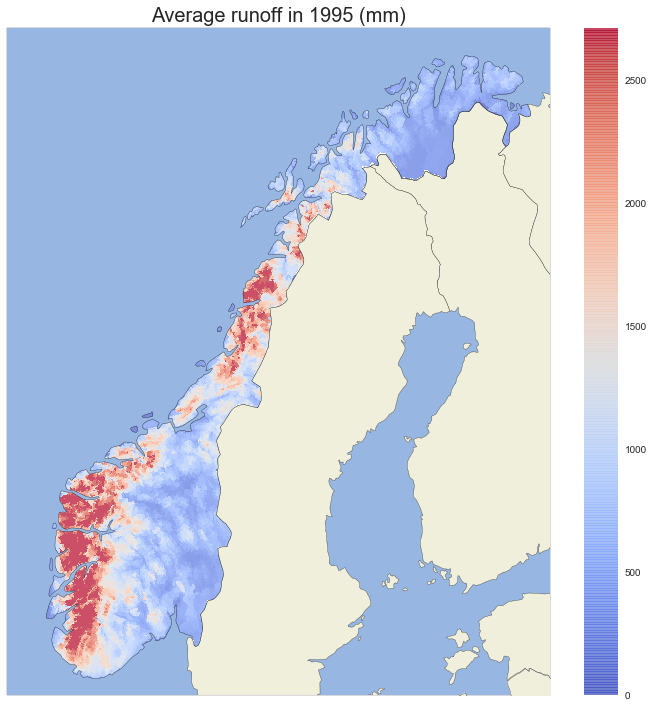

In [20]:
# Define co-ord system
crs = ccrs.AlbersEqualArea(central_longitude=15, 
                           central_latitude=65, 
                           false_easting=650000, 
                           false_northing=800000,
                           standard_parallels=(55, 75))

# Setup fig
fig = plt.figure(figsize=(10, 10))
    
# Read data
data = nivapy.spatial.read_geotiff(reg_ras, band=1)[0]

# Plot
ax = fig.add_subplot(1, 1, 1, projection=crs)
ax.set_extent(bbox, crs=crs)
ax.set_title('Average runoff in %s (mm)' % year, fontsize=20)
cax = ax.imshow(data, 
                zorder=1,
                extent=bbox,
                cmap='coolwarm', 
                alpha=0.7, 
                interpolation='none',
                vmax=np.nanpercentile(data, 95))

# Add colourbar
cbar = fig.colorbar(cax)

# Get countries
shp = cartopy.io.shapereader.natural_earth(resolution='50m',
                                           category='cultural',
                                           name='admin_0_countries')
reader = cartopy.io.shapereader.Reader(shp)
countries = reader.records()

# Loop over records
for country in countries:
    if country.attributes['NAME'] == 'Norway':
        # Transparent
        ax.add_geometries(country.geometry, 
                          ccrs.PlateCarree(), # CRS of Natural Earth data
                          facecolor='none', 
                          edgecolor='black',
                          zorder=5,)
    else:
        # Opaque
        ax.add_geometries(country.geometry, 
                          ccrs.PlateCarree(), # CRS of Natural Earth data
                          facecolor=cfeature.COLORS['land'],
                          edgecolor='black',
                          zorder=5)

# Add sea
ax.add_feature(sea_50m, zorder=4)

plt.tight_layout()

### 5.3. Runoff zonal statistics

In [21]:
# Path to "1000 lakes" catchments
shp_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\NOPE\Metals\GIS\Vector\lakes_1k_catchments.shp')

# Calc stats
ro_df = nivapy.spatial.zonal_stats(shp_path, reg_ras)
    
# Set index
ro_df.index = ro_df['fid']
del ro_df['fid']

# Get just mean and std. dev.
ro_df = ro_df[['mean', 'std']]
ro_df.columns = ['ro_mean_mm', 'ro_std_mm']

# Join to catchment data
cat_df = pd.merge(cat_df, ro_df, how='left',
                  left_index=True, right_index=True)

cat_df.head()

lake_id            name      alt_avg    slp_avg     slp_var  area_km2  \
0   118-1-7          HOH113   117.429493   1.283039    2.518281    0.4296   
1   227-2-1            Heia   220.582426   6.982528   41.813836   17.5300   
2  1266-2-1  Svadfjellvatni   869.364951  15.021529  142.861185    1.4942   
3   834-4-7     Holmavatnet  1158.677692   8.045503   77.777198   54.2214   
4  1736-1-2       Fiskløysa   647.525184   7.544434   73.569782    0.2438   

   moss_cr_mean  moss_cr_std  moss_ni_mean  moss_ni_std     ...      \
0      1.313870     0.007830      1.817870     0.013648     ...       
1      1.217668     0.014041      1.289349     0.022165     ...       
2      0.514820     0.005723      1.222819     0.016574     ...       
3      0.493505     0.042375      1.392313     0.022372     ...       
4      0.506990     0.000127      1.184942     0.001080     ...       

   geo_cu_mean  geo_cu_std  geo_zn_mean  geo_zn_std  geo_as_mean  geo_as_std  \
0    14.791145    0.029488    67.220087    0.092955     3.380326    0.001727   
1    15.004085    0.289037    66.771715    0.867881     2.667793    0.036659   
2    18.981607    0.370123    51.090220    0.548855     5.221988    0.211180   
3    33.723264    1.090034    82.994366    2.184810     7.304407    0.237982   
4    15.443104    0.002450    40.332142    0.025757     4.717668    0.014869   

   geo_pb_mean  geo_pb_std   ro_mean_mm   ro_std_mm  
0    26.131042    0.048094   400.314941    0.000000  
1    21.318825    0.090940   649.708445    0.000010  
2    37.465154    0.423776  4486.477865  194.545015  
3    45.404882    1.360928  2289.309332   58.028553  
4    13.962950    0.000220  1268.751343    0.000000  

[5 rows x 34 columns]

## 6. Estimate point discharges for each catchment

We also need to know the point discharges recorded in each of the lake catchments. 

### 6.1. Extracts the point discharge data from RESA2

In [22]:
# Group point metal inputs by regine 
sql = ("SELECT a.anlegg_nr, "
       "  a.lon_utl, "
       "  a.lat_utl, "
       "  b.name, "
       "  b.unit, "
       "  (c.value * d.factor) as value "
       "FROM RESA2.RID_PUNKTKILDER a, "
       "RESA2.RID_PUNKTKILDER_OUTPAR_DEF b, "
       "RESA2.RID_PUNKTKILDER_INPAR_VALUES c, "
       "RESA2.RID_PUNKTKILDER_INP_OUTP d "
       "WHERE a.anlegg_nr = c.anlegg_nr "
       "AND d.in_pid = c.inp_par_id "
       "AND d.out_pid = b.out_pid "
       "AND b.name IN ('As', 'Cd', 'Cr', 'Cu', 'Ni', 'Pb', 'Zn') "
       "AND c.year = %s " % year)
pt_df = pd.read_sql(sql, ora_eng)

# Restructure
pt_df['par'] = pt_df['name'] + '_' + pt_df['unit']
del pt_df['name'], pt_df['unit']
pt_df.set_index(['anlegg_nr', 'lon_utl', 'lat_utl', 'par'], inplace=True)
pt_df = pt_df.unstack(level='par')

# Tidy
pt_df.columns = pt_df.columns.get_level_values(1)
pt_df.columns.name = ''
pt_df.reset_index(inplace=True)
pt_df.dropna(subset=['lon_utl', 'lat_utl'], inplace=True)

# Fill NaN with 0
pt_df.fillna(0, inplace=True)

pt_df.head()

anlegg_nr    lon_utl    lat_utl  As_tonn  Cd_tonn  Cr_tonn   Cu_tonn  \
0  0101.0022.01  11.424077  59.115619      0.0  0.00000      0.0  0.000020   
1  0104.0033.01  10.678090  59.420319      0.0  0.00000      0.0  0.004620   
2  0105.0013.01  11.153293  59.292217      0.0  0.00000      0.0  0.001259   
3  0105.0014.01  11.111798  59.278244      0.0  0.00000      0.0  7.426000   
4  0105.0029.01  11.106693  59.289239      0.0  0.00018      0.0  0.004400   

    Ni_tonn  Pb_tonn   Zn_tonn  
0  0.000000  0.00000  0.000020  
1  0.005390  0.00000  0.001120  
2  0.006127  0.00000  0.001897  
3  0.000000  0.00000  0.000000  
4  0.000300  0.00036  0.003500

### 6.2. Assign point discharges to catchments

The code below converts the RESA2 data to a spatial dataset and then loops over the lake catchments. Point discharges for each parameter in each catchment are then summed.

In [23]:
# Convert RESA data to gdf
geometry = [Point(xy) for xy in zip(pt_df['lon_utl'], pt_df['lat_utl'])]
del pt_df['lon_utl'], pt_df['lat_utl']
crs = {'init': 'epsg:4326'}
pt_gdf = gpd.GeoDataFrame(pt_df, crs=crs, geometry=geometry)

# Reproject to common crs
pt_gdf = pt_gdf.to_crs(crs_ax.projection.proj4_init)

# Spatial join to assign points to catchments
pts_in_cat = gpd.sjoin(pt_gdf, cat_gdf[['geom',]], 
                       how='left', op='within')
pts_in_cat.dropna(subset=['index_right',], inplace=True)

# Get cols of interest
cols = [i for i in pts_in_cat.columns if len(i.split('_')[0])==2]
pts_in_cat = pts_in_cat[['index_right',]+cols]

# Sum inputs to each catchment
pts_in_cat = pts_in_cat.groupby('index_right').sum()

# Rename cols
pts_in_cat.columns = ['pt_%s' % i.split('_')[0].lower()
                      for i in pts_in_cat.columns]

# Index to int
pts_in_cat.index = pts_in_cat.index.astype(int)

pts_in_cat

pt_as    pt_cd  pt_cr    pt_cu     pt_ni    pt_pb      pt_zn
index_right                                                              
57             0.0  0.00870    0.0  2.00000  0.000000  0.00000   7.000000
106            0.0  0.00000    0.0  0.90000  0.000000  0.00000  10.500000
262            0.0  0.00000    0.0  0.00000  0.003400  0.00000   0.000000
274            0.0  0.00000    0.0  0.00000  0.024990  0.00000   0.001990
472            0.0  0.00011    0.0  0.20107  0.700235  0.00235   0.010641
566            0.0  0.00109    0.0  0.02823  0.061800  0.00170   0.002520
595            0.0  0.00000    0.0  0.00000  0.004530  0.00000   0.000000
628            0.0  0.00000    0.0  0.00000  0.000000  0.00146   0.010240

So only a small number of the lake catchments actually have known point inputs, but in some cases (e.g. for Cu and Zn), these inputs are substantial.

In [24]:
# Join to catchment data
cat_df = pd.merge(cat_df, pts_in_cat, how='left',
                  left_index=True, right_index=True)

# Fill NaN with zero
for col in pts_in_cat.columns:
    cat_df[col].fillna(0, inplace=True)

cat_df.head()

lake_id            name      alt_avg    slp_avg     slp_var  \
index_right                                                                 
0             118-1-7          HOH113   117.429493   1.283039    2.518281   
1             227-2-1            Heia   220.582426   6.982528   41.813836   
2            1266-2-1  Svadfjellvatni   869.364951  15.021529  142.861185   
3             834-4-7     Holmavatnet  1158.677692   8.045503   77.777198   
4            1736-1-2       Fiskløysa   647.525184   7.544434   73.569782   

             area_km2  moss_cr_mean  moss_cr_std  moss_ni_mean  moss_ni_std  \
index_right                                                                   
0              0.4296      1.313870     0.007830      1.817870     0.013648   
1             17.5300      1.217668     0.014041      1.289349     0.022165   
2              1.4942      0.514820     0.005723      1.222819     0.016574   
3             54.2214      0.493505     0.042375      1.392313     0.022372   
4              0.2438      0.506990     0.000127      1.184942     0.001080   

             ...    geo_pb_std   ro_mean_mm   ro_std_mm  pt_as  pt_cd  pt_cr  \
index_right  ...                                                               
0            ...      0.048094   400.314941    0.000000    0.0    0.0    0.0   
1            ...      0.090940   649.708445    0.000010    0.0    0.0    0.0   
2            ...      0.423776  4486.477865  194.545015    0.0    0.0    0.0   
3            ...      1.360928  2289.309332   58.028553    0.0    0.0    0.0   
4            ...      0.000220  1268.751343    0.000000    0.0    0.0    0.0   

             pt_cu  pt_ni  pt_pb  pt_zn  
index_right                              
0              0.0    0.0    0.0    0.0  
1              0.0    0.0    0.0    0.0  
2              0.0    0.0    0.0    0.0  
3              0.0    0.0    0.0    0.0  
4              0.0    0.0    0.0    0.0  

[5 rows x 41 columns]

## 7. Lake chemistry data

The next step is to add data from the 1995 "1000 lake" survey.

### 7.1. Search RESA2 stations

In [25]:
# Search projects
prj_df = nivapy.da.search_projects("project_name LIKE 'Regional%'", ora_eng)
prj_df

project_id project_number               project_name contact_person  \
0          27           None  Regionalundersøkelse 1995           RESA   
1          81           None  Regionalundersøkelse 1986           None   

                                 project_description  
0  Tusensjøersundersøkelsen 1995 med etterfølgend...  
1  Tusensjøers undersøkelsen 1986 samt nyere data...

In [26]:
# Get stations for 1995 survey
stn_df = nivapy.da.select_project_stations([27,], ora_eng)

print 'Number of stations:', len(stn_df)
stn_df.head()

Number of stations: 1006


station_id station_code    station_name   latitude  longitude  altitude
0         115      831-501       BrÃ¥rvatn  59.294921   7.727118     902.0
1         116     1640-603       Tufsingen  62.612294  11.876558     781.0
2         125     2030-607    St.Valvatnet  69.694975  30.656211     157.0
3         135     1228-501      Steinavatn  59.859877   6.578783    1047.0
4         166       1018-4  Kleivsetvannet  58.119559   7.664899      93.0

It is useful to compare the station locations in RESA2 to the catchment data provided by Anders. In order to do this in an interactive way, I need to simplify the catchment polygons. The code below uses PostGIS' `ST_SimplifyPreserveTopology` to create a lower-resolution version of the catchment dataset. It also extracts only the polygons located within Norway, which should keep file sizes manageable. Downsampling is achieved using the [Douglas-Peucker algorithm](https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm), but with the additional constraint that topological relationships are preserved. I have allowed vector nodes to be moved by up to a maximum of 1 km during the simplification process.

In [27]:
# Extract simplified catchments and avg_slope data 
sql = ("SELECT ST_SimplifyPreserveTopology(geom, 1000) AS geom, "
       "  slope_average AS slp_avg "
       "FROM niva_work.nope_metals.ecco_biwa "
       "WHERE nation = 'Norway'")
crs = {'init': 'epsg:25833'} # UTM Zone 33N ETRS89
gdf = gpd.GeoDataFrame.from_postgis(sql, geom_col='geom', crs=crs, con=pg_eng)

# Choropleth of avg_slp from catchment data
map1 = nivapy.spatial.choropleth_from_gdf(gdf, 'slp_avg', fill_opacity=0.5,
                                          legend_name='Average slope (degrees)')

# Add station locs from RESA2
map1 = nivapy.spatial.quickmap(stn_df, popup='code', map_obj=map1)

map1

### 7.2. Extract water chemistry from "1000 lakes" survey

The code below extracts all the 1995 chemistry data for the "1000 lakes" survey.

In [28]:
# Pars of interest
par_list = ['Ag', 'As', 'Pb', 'Cd', 'Cu', 'Zn', 'Ni', 'Cr', 'pH', 'TOC']

# Container for results
df_list = []

# Loop over stations
for stn_id in stn_df['station_id']:
    # Get all Al data
    wc_df, dup_df = nivapy.da.extract_water_chem(stn_id, par_list,
                                                 '1995-01-01', 
                                                 '1995-12-31',
                                                 ora_eng,
                                                 plot=False)
    
    # Tidy
    wc_df['station_id'] = stn_id
    wc_df.reset_index(inplace=True)
    df_list.append(wc_df)  

# Combine output
wc_df = pd.concat(df_list, axis=0)

#  Annual means for each site
wc_df['year'] = wc_df['sample_date'].dt.year
an_df = wc_df.groupby(['year', 'station_id']).mean()

# Reset index
an_df.columns = ['wc_%s' % i.split('_')[0].lower()
                 for i in an_df.columns]
an_df.reset_index(inplace=True)
del an_df['year']

# Join and drop NaN
wc_df = pd.merge(stn_df[['station_id', 'latitude', 'longitude']],
                 an_df, how='left', on='station_id')
wc_df.dropna(subset=['latitude', 'longitude'], inplace=True)

# Set negative values to zero
wc_df[wc_df < 0] = 0

wc_df.head()

station_id   latitude  longitude  wc_ag  wc_as  wc_cd  wc_cr  wc_cu  wc_ni  \
0         115  59.294921   7.727118    0.0    NaN   0.03    0.0    0.3    0.2   
1         116  62.612294  11.876558    NaN    0.0   0.00    0.0    0.0    0.0   
2         125  69.694975  30.656211    NaN    NaN    NaN    NaN    2.0    6.0   
3         135  59.859877   6.578783    NaN    NaN   0.02    0.5    1.5    0.2   
4         166  58.119559   7.664899    0.0    NaN   0.17    0.2    0.9    0.8   

   wc_pb  wc_toc  wc_zn  wc_ph  
0   0.35    0.55    3.2   5.79  
1   0.05    1.50    0.9   6.48  
2    NaN    1.20    NaN   6.44  
3   4.09    0.20    2.1   5.11  
4   1.39    4.70   19.8   5.00

### 7.3. Link lake chemistry to moss and geochemistry datasets

This step should be fairly straightforward, but it looks as though the lake IDs in Anders' dataset have been accidentally truncated to 8 characters. This means that, for example, Skeivatnet, which has code `1001-1-55` in RESA2, appears in the catchment dataset as `1001-1-5`. Unfortunately this is not straightforward to correct, because there are several other catchments with codes beginning `1001-1-5`. What's more, because many of the catchments overlap, it is not easy to uniquely determine the catchment polygon corresponding to a particular set of site co-ordinates. To make matters even worse, many of the lake names were originally entered into RESA2 using an incorrect character encoding so that, for example, `Bjørfarvatnet` appears in the database as `BjÃ¸rfarvatnet`. This means it will not always be possible to match stations to catchments precisely, even using a combination of partial lake IDs and lake names.

The code below implements some logic to try to resolve these issues.

In [29]:
# Join stn_code and name to water chem
wc_df = pd.merge(wc_df, stn_df[['station_id', 'station_code', 'station_name']],
                 how='left', on='station_id')

# Add unique catchment ID to cat_df (as lake_id is broken)
cat_df['cat_id'] = cat_df.index

# Container for matches
match_list = []

# Loop over chem data
for idx, row in wc_df.iterrows():
    # Get site info
    code = row['station_code']
    name = row['station_name']
    
    # Has the lake ID been truncated?
    if len(code) > 8:
        # Truncated
        tr_code = code[:8]
        
        # Get matches based on truncated code
        code_mat_df = cat_df.query('lake_id == @tr_code')
        
        # Is there a unique match for the truncated code?
        if len(code_mat_df) == 1:
            # Yes
            match_list.append(code_mat_df['cat_id'].values[0])
            
        else:
            # No. Can we match based on name as well?
            name_mat_df = code_mat_df.query('name == @name')
            
            # Do we now have a unique match?
            if len(name_mat_df) == 1:
                # Yes
                match_list.append(name_mat_df['cat_id'].values[0])
                
            elif len(name_mat_df) == 0:
                # No matches found
                match_list.append('No match')
            
            else:
                # Multiple matches
                match_list.append('Multiple matches')
    else:
        # Not truncated. Should be able to match lake ID exactly
        code_mat_df = cat_df.query('lake_id == @code')
        
        # Is there a unique match?
        if len(code_mat_df) == 1:
            # Yes
            match_list.append(code_mat_df['cat_id'].values[0])        
        
        elif len(code_mat_df) == 0:
            # No matches found
            match_list.append('No match')

        else:
            # Can we match on name as well?
            name_mat_df = code_mat_df.query('name == @name')
            
            # Do we now have a unique match?
            if len(name_mat_df) == 1:
                # Yes
                match_list.append(name_mat_df['cat_id'].values[0])
                
            elif len(name_mat_df) == 0:
                # No matches found
                match_list.append('No match')
            
            else:
                # Multiple matches
                match_list.append('Multiple matches')
            
# Add col to wc_df
wc_df['match_ids'] = match_list

# Save
wc_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
          r'\NOPE\Metals\lake_1k_chem.csv')
wc_df.to_csv(wc_csv, encoding='utf-8')

In [30]:
# Get how many are matched
df = wc_df.query('(match_ids != "No match") and '
                 '(match_ids != "Multiple matches")').reset_index(drop=True)

print 'Total number of chemistry stations in RESA2:', len(wc_df)
print 'Total number of polygons in catchmnet datasets:', len(cat_df)
print 'Number of chemistry stations uniquely matched to polygons:', len(df)

# Print unmatched
nomat_df = wc_df.query('(match_ids == "No match") or '
                       '(match_ids == "Multiple matches")').reset_index(drop=True)

nomat_df

Total number of chemistry stations in RESA2: 1004
Total number of polygons in catchmnet datasets: 990
Number of chemistry stations uniquely matched to polygons: 960


station_id   latitude  longitude  wc_ag  wc_as  wc_cd  wc_cr  wc_cu  \
0          115  59.294921   7.727118    0.0    NaN   0.03    0.0    0.3   
1          116  62.612294  11.876558    NaN  0.000   0.00    0.0    0.0   
2          125  69.694975  30.656211    NaN    NaN    NaN    NaN    2.0   
3          135  59.859877   6.578783    NaN    NaN   0.02    0.5    1.5   
4          166  58.119559   7.664899    0.0    NaN   0.17    0.2    0.9   
5          171  66.750981  15.410237    0.0    NaN   0.00    0.0    0.0   
6          187  61.151399  11.623626    0.0    NaN   0.00    0.1    0.4   
7           36  58.605252   8.036265    NaN    NaN    NaN    NaN    NaN   
8           42  58.203996   6.764866    NaN    NaN    NaN    NaN    NaN   
9         3170  60.213000   9.764000    NaN  0.134   0.00    0.2    0.4   
10        3488  60.083846   7.143141    NaN  0.369   0.00    0.2    1.1   
11        3198  59.334000   9.997000    NaN    NaN    NaN    NaN    NaN   
12        3244  59.382000   8.465000    0.0    NaN   0.03    0.0    0.5   
13        3348  58.766000   7.437000    0.0    NaN   0.03    0.0    0.3   
14        3350  58.842480   7.339997    NaN  0.160   0.00    0.0    0.3   
15        3363  58.726000   7.040000    NaN  0.205   0.03    0.0    0.3   
16        3374  58.947000   7.115000    NaN  0.110   0.00    0.0    0.5   
17        3376  58.819000   6.894000    NaN  0.184   0.00    0.0    0.0   
18        3436  59.169000   6.356000    NaN    NaN    NaN    NaN    NaN   
19        3474  60.029401   6.840693    NaN  0.000   0.00    0.9    1.7   
20        3475  59.978856   7.062284    0.0    NaN   0.00    1.2    0.0   
21        3478  59.840000   6.631000    NaN    NaN    NaN    NaN    NaN   
22        3796  70.181000  19.905000    0.0    NaN   0.00    0.2    1.1   
23        3879  69.628000  25.323000    NaN    NaN    NaN    NaN    NaN   
24        3598  62.119000   7.313000    NaN    NaN    NaN    NaN    NaN   
25       15705  59.205535   8.621778    NaN  0.000   0.03    0.0    0.0   
26       15712  58.475994   8.460996    NaN    NaN    NaN    NaN    NaN   
27       16132  62.001020  11.589488    NaN    NaN    NaN    NaN    NaN   
28       17876  60.660220   9.373200    0.0    NaN   0.00    0.0    0.4   
29       17942  59.181995   8.688987    NaN    NaN    NaN    NaN    NaN   
30       17957  59.803999   9.092983    NaN    NaN    NaN    NaN    NaN   
31       17966  59.402995   8.657992    NaN    NaN    NaN    NaN    NaN   
32       17988  59.321996   7.973988    NaN    NaN    NaN    NaN    NaN   
33       18013  60.035994   8.055995    NaN    NaN    NaN    NaN    NaN   
34       18073  58.893710   8.347547    0.0    NaN   0.13    0.0    0.6   
35       18158  58.406390   6.884722    NaN    NaN    NaN    NaN    NaN   
36       17888  60.355944   9.910718    NaN    NaN    NaN    NaN    NaN   
37       18042  58.613998   8.979000    NaN    NaN    NaN    NaN    NaN   
38       17809  60.484068  11.800313    NaN    NaN    NaN    NaN    NaN   
39       17854  60.629127  10.566392    NaN  0.196   0.00    0.0    0.6   
40       17867  60.698999  10.052985    NaN    NaN    NaN    NaN    NaN   
41       15860  69.488029  27.084386    NaN    NaN    NaN    NaN    NaN   
42         137  60.439000   7.784000    NaN  0.000   0.00    0.0    0.3   
43        3833  68.645000  24.852000    NaN  0.000   0.00    0.2    0.3   

    wc_ni  wc_pb  wc_toc  wc_zn  wc_ph station_code            station_name  \
0     0.2   0.35    0.55    3.2   5.79      831-501               BrÃ¥rvatn   
1     0.0   0.05    1.50    0.9   6.48     1640-603               Tufsingen   
2     6.0    NaN    1.20    NaN   6.44     2030-607            St.Valvatnet   
3     0.2   4.09    0.20    2.1   5.11     1228-501              Steinavatn   
4     0.8   1.39    4.70   19.8   5.00       1018-4          Kleivsetvannet   
5     0.0   0.00    0.49    0.6   6.03     1840-601             Kjemåvatnet   
6     0.3   0.38    4.50    2.3   5.54      429-601               Holmsjøen

This approach works reasonably well - I can now match 960 stations, compared to about 500 when just using lake IDs directly. 

There are still 30 polygons in the catchment dataset that I can't match to the RESA2 data, and with some more manual cleaning it might be possible to resolve some of these issues too. However, for now I'll continue just using the 960 stations matched above.

In [31]:
# Combine catchment and water chem data
df = pd.merge(df, cat_df, how='left', left_on='match_ids',
              right_on='cat_id')

# Reorder cols and tidy
stn_cols = ['station_id', 'station_code', 'name', 'latitude', 'longitude']
oth_cols = [i for i in df.columns if i not in stn_cols]
df = df[stn_cols + oth_cols]
del df['match_ids'], df['station_name'], df['lake_id'], df['cat_id']

# Save
comb_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\NOPE\Metals\lake_1k_all_data.csv')
df.to_csv(comb_csv, encoding='utf-8', index=False)

df.head()

station_id station_code           name   latitude  longitude  wc_ag  wc_as  \
0         193    1725-3-14  Bjørfarvatnet  64.277881  10.986769    NaN  0.000   
1          10      221-1-2      Langtjern  59.808647  11.850279    0.0    NaN   
2           9      101-2-7      Hokksjøen  59.004421  11.563584    NaN  0.491   
3          11     402-2-13     Sætertjern  60.060220  12.446706    0.0    NaN   
4          12     419-1-25      Mjøgsjøen  60.328576  11.842177    0.0    NaN   

   wc_cd  wc_cr  wc_cu  ...    geo_pb_std   ro_mean_mm  ro_std_mm  pt_as  \
0   0.00    0.0    0.0  ...      0.029028  1584.427220  26.050219    0.0   
1   0.03    0.2    0.4  ...      0.051241   535.643555   0.000000    0.0   
2   0.06    0.5    0.5  ...      0.039812   376.627667  16.109088    0.0   
3   0.13    0.2    0.5  ...      0.035459   515.430731  11.806941    0.0   
4   0.04    0.3    0.4  ...      0.034034   390.276245  19.008820    0.0   

   pt_cd  pt_cr  pt_cu  pt_ni  pt_pb  pt_zn  
0    0.0    0.0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0.0    0.0    0.0    0.0  
2    0.0    0.0    0.0    0.0    0.0    0.0  
3    0.0    0.0    0.0    0.0    0.0    0.0  
4    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 54 columns]

## 8. Explore statistical relationships

All the processing above has created a single, large data table, which hopefully includes some interesting relationships. The table has 960 rows and 54 columns, where each row corresponds to a lake in the 1995 "1000 lakes" survey and each column corresponds to a different variable or catchment characteristic. To keep things compact, I have not inlcuded much metadata (e.g. units) in the table itself, but the following gives a brief overview:

 * Columns named `'wc_'` are for water chemistry, as recorded in RESA2. All metal concentrations are in $\mu g.l^{-1}$, TOC is in $mg C.l^{-1}$ and pH is dimensionless. All measurements were taken during 1995 <br><br>
 
 * `'alt_'` is altitude in metres and `'slp_'` is slope in degrees <br><br>
 
 * `'moss_'` identifies values summarised from the interpolated moss data from 1990. The raw data files do not provide units, but the values in my datasets (see section 2.2, above) look comparable to those given in [this report](https://brage.bibsys.no/xmlui/bitstream/handle/11250/2435067/28-2016-Atmospheric%2bdeposition%2bof%2bheavy%2bmetals%2bin%2bNorway-HTU-KAP.pdf?sequence=1&isAllowed=y), where the units are specified as $mg.kg^{-1}$. These values are assumed to reflect atmospheric deposition over time scales of a few years <br><br>
 
 * `'geo_'` identifies values summarised from the interpolated NGU geochemical data. All values are in $mg.kg^{-1}$ and the data are assumed to represent background metal concentrations in catchment sediments over long time periods. The measurements themselves were taken during 1984-85 <br><br>
 
 * `'pt_'` identifies point inputs reported to Miljødirektoratet from licensed discharge locations (industry etc.) during 1995. All values are in tonnes per year <br><br>
 
 * `'ro_'` is runoff in mm for 1995, derived by combining the NVE modelled hydrology datasets with maps of long-term average runoff
 
An Excel version of this data table is here:

C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet\NOPE\Metals\lake_1k_all_data.xlsx

**Note:** Not all data sources include all the metals of interest:

 * The water chemistry dataset comprises Ag, Cr, Ni, Cu, Zn, As, Cd and Pb <br><br>
 
 * The moss surveys and point discharge datasets include Cr, Ni, Cu, Zn, As, Cd and Pb (i.e. not Ag) <br><br>
 
 * The geochemical surveys include Cr, Ni, Cu, Zn, As and Pb (i.e not Ag or Cd)
 
I have found relatively little information regarding the behaviour of Ag, and in the water chemistry data concentrations are usually so low as to be on or very close to the LOD. Furthermore, for roughly half of the lake samples taken, Ag was not reported. I will therefore ignore Ag from now on.

Cd is not included in the geochemical data, but my reading suggests that it should be dominated by LRTAP, so I will keep it in the analysis and simply assume the geological inputs are zero. This is probably not appropriate, but it's worth a go to begin with.

In [32]:
# Read CSV (avoids having to re-run entire notebook)
csv_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\NOPE\Metals\lake_1k_all_data.csv')
data_df = pd.read_csv(csv_path, encoding='utf-8')

# Add columns of zeros for geo_cd - see above
data_df['geo_cd_mean'] = 0
data_df['geo_cd_std'] = 0

# Add mean annual flow (m3/s) based on area and runoff
data_df['q_mean'] = (1000*data_df['ro_mean_mm']*data_df['area_km2'] / 
                     (365*24*60*60))

### 8.1. Data exploration

A first step is to plot histograms of all the variables in order to get a feel for the distributions of the data. Note the following issues:

 * In many cases, the overwhelming majority of measured values are zero. In the water chemistry data this is a little strange, because values are usually reported with detection limits (i.e. not zero) and, for some metals, it is clear there are both LOD values and zeros present in the same dataset. I'm not sure what's going on here, but lakes with zero concentration are problematic for regression, because the predictor variables (moss, geochemistry etc.) are never exactly zero. I therefore propose filtering zeros from the water chemistry datasets prior to regression analysis <br><br>
 
 * In some cases there are *huge* outliers in the water chemistry data. I suspect some of the more extreme values are unreasonable as estimates of annual average lake concentration (which is what we're assuming they represent) and I am therefore tempted to remove them from the analysis too (e.g. discard the upper 5% of values due to suspected analysis errors and/or sample contamination). **This basically amounts to "data dredging", and I'd like to avoid it if possible**, but it's nevertheless useful for visualisation, as it avoids the axis scales becoming too compressed.
 
The code below defines a convenience function to extract the data of interest for any variable and to apply different filtering and transformation options.

In [33]:
def get_par_data(data_df, par, log10=False, standardise=False, clip=False):
    """ Convenience function to extract data for a specified parameter.
        
        Removes any NaNs in the df, and any zeros in the water chemistry 
        data. Optionally applies log-10 transformation and/or
        standardisation and/or outlier 'clipping' (note that some of these 
        methods are 'dodgy'!)
        
    Args:
        data_df:     Dataframe. Full data produced by the analysis above
        par:         Str. Parameter of interest
        log10:       Bool. Apply log base 10 tansformation?
        standardise: Bool. Standardise?
        clip:        Float or False. If float, clip off the upper 
                     100*(1 - clip)% of values as 'unreasonable outliers'
                     
    Returns:
        Dataframe
    """
    # Response var
    resp = ['wc_%s' % par,]
    
    # Static explanatory vars
    static = ['slp_avg', 'area_km2', 'ro_mean_mm', 'q_mean', 'wc_toc', 'wc_ph']
    
    # Par-specific explanatory vars
    par_spec = ['moss_%s_mean' % par, 'geo_%s_mean' % par, 'pt_%s' % par]
    
    # Extract data
    df = data_df[resp + static + par_spec].copy()
    
    # Drop any NaN
    df.dropna(how='any', inplace=True)
    
    # Remove zeros
    df = df[df['wc_%s' % par] > 0]   

    # Clip off upper 5% as 'unreasonable outliers'
    if clip:
        assert isinstance(clip, float), 'Clip must be False or float between 0 and 1.'
        pct = df['wc_%s' % par].describe(percentiles=[clip,]).ix['%s%%' % int(clip*100)]
        df = df[df['wc_%s' % par] < pct]
    
    # Log transform
    if log10:
        df = np.log10(df)
    
    # Standardise
    if standardise:
        # Standardise
        scaler = StandardScaler()
        df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)    
        
    return df

I'll begin with a scatterplot matrix for Pb, using KDE-smoothed histograms along the diagonal and "lowess" (locally-weighted) regression lines for each pair of variables

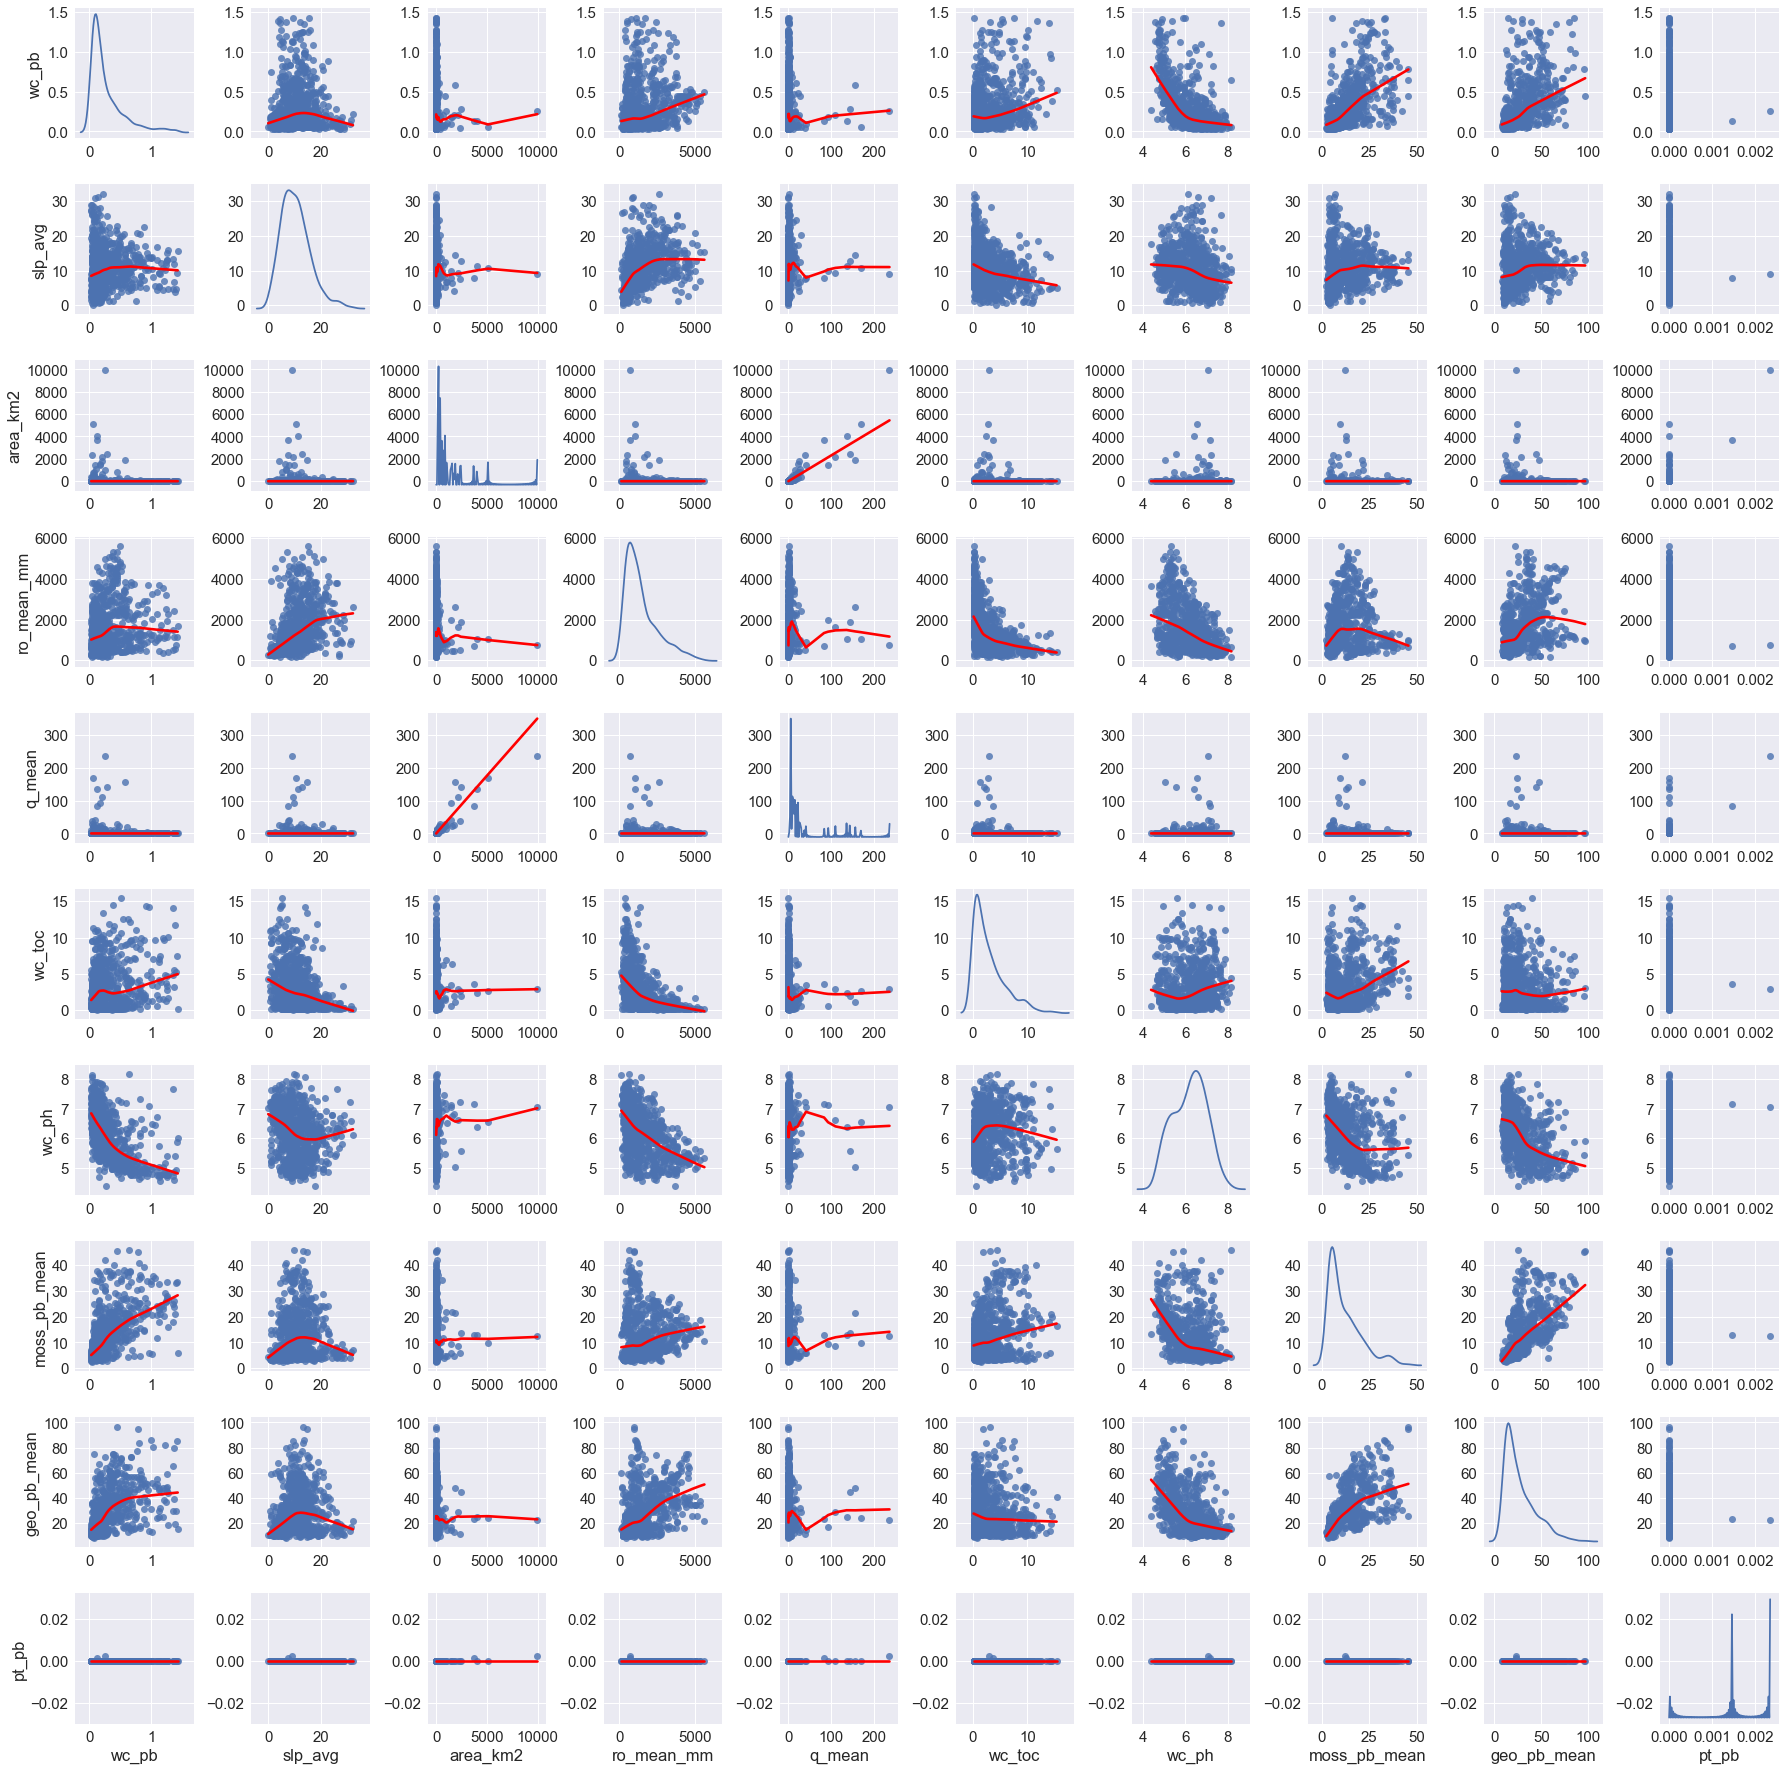

In [34]:
# Specify parameter
par = 'pb'

# Get data, clipping upper 5%
df = get_par_data(data_df, par, clip=0.95)

# Scatterplot matrix
with sn.plotting_context('notebook', font_scale=1.5):
    sn.pairplot(df, 
                kind='reg', 
                diag_kind='kde', 
                plot_kws=dict(lowess=True, 
                              line_kws=dict(color='red')))

Some points to note:

 * It is clear that the point input data (e.g. from industrial discharges; lower row of plots) will have limited use in this analysis, as only a small number of catchments have non-zero point inputs. I will therefore not be able to derive meaningful statistical relationships based on the point data, but I will nevertheless include point sources as constants in subsequent models, as they may be locally important <br><br>
 
 * Virtually all of the histograms are strongly right-skewed <br><br>
 
 * There is a huge amount of scatter in the data, with no clearly defined relationships. Nevertheless, the lowess regression lines do pick up some interesting patterns <br><br>
 
 * The upper row of plots, with the response variable (Pb concentration in lakes) on the y-axis, is the most interesting. In particular, there is evdience for monotonic relationships between the response variable and the following quantities: runoff, TOC, pH, mosses and geochemistry. The code below focuses on just these relationships.

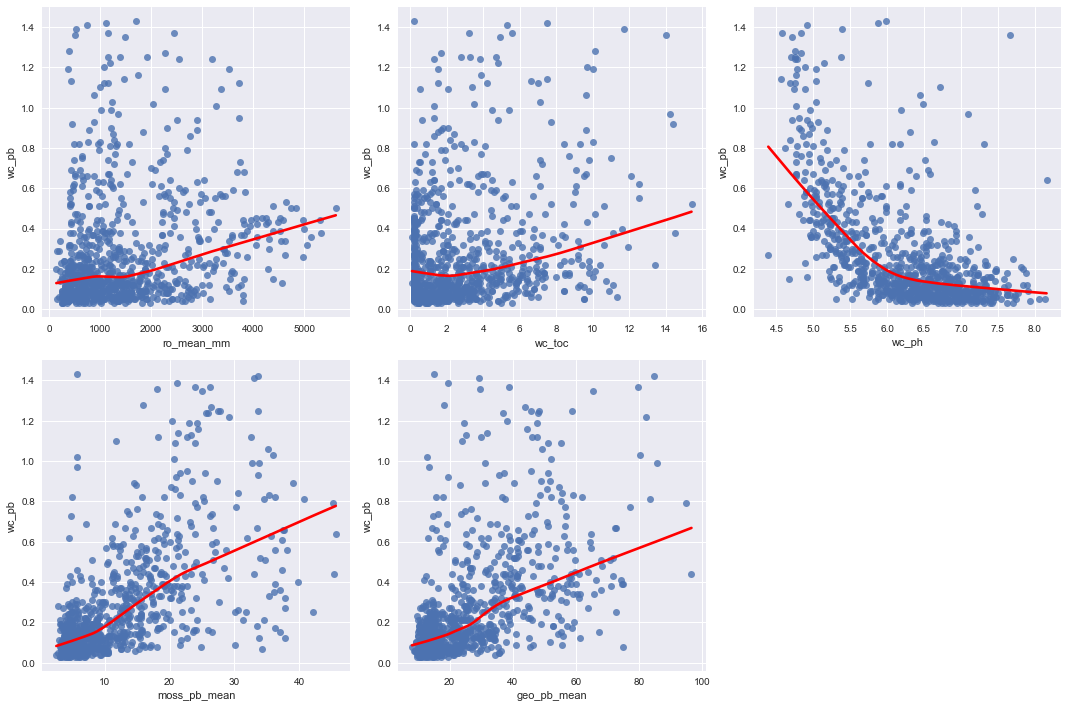

In [35]:
# Get subset of cols
cols = ['ro_mean_mm', 'wc_toc', 'wc_ph',
        'moss_%s_mean' % par, 'geo_%s_mean' % par]

# Plot
fig = plt.figure(figsize=(15,10))

for idx, exp_var in enumerate(cols):
    ax = fig.add_subplot(2, 3, idx+1)
    sn.regplot(x=exp_var, y='wc_%s' % par, data=df,
               lowess=True, line_kws=dict(color='red'))
    
plt.tight_layout()

There is obviously *a lot* of scatter in these data, but the lowess lines do a pretty good job of picking out overall patterns and, in general, the relationships make sense from a scientific perspective. For example:

 * Metals are often bound to particulates, especially e.g. POC. It is therefore not surprising that there are positive relationships with TOC and runoff (the latter presumably because higher runoff is associated with greater erosion and more particulates) <br><br>
 
 * There is a negative relationship with pH, because metals are more mobile under acidic conditions. What's more, the shape of the lowess curve approximates exponential decay, which is perhaps to be expected given how pH is defined. If I want to apply a linear model, it is probably a good idea to transform pH, for example by working with H+ concentration instead ($[H^+] = 10^{-pH}$). This is because the lowess curves imply that, although the relationship with pH is non-linear, the relationship with [H+] could be approximately linear (which also makes reasonable sense from a scientific point of view) <br><br>
 
 * There are clear positive (and approximately linear) relationships with both moss concentrations (atmospheric deposition) and geochemistry (soil/weathering inputs)

The code below produces similar plots for all metals, focusing on the five explanatory variables identified above. Each row corresponds to a different metal, and the y-axis is always lake metal concentration.

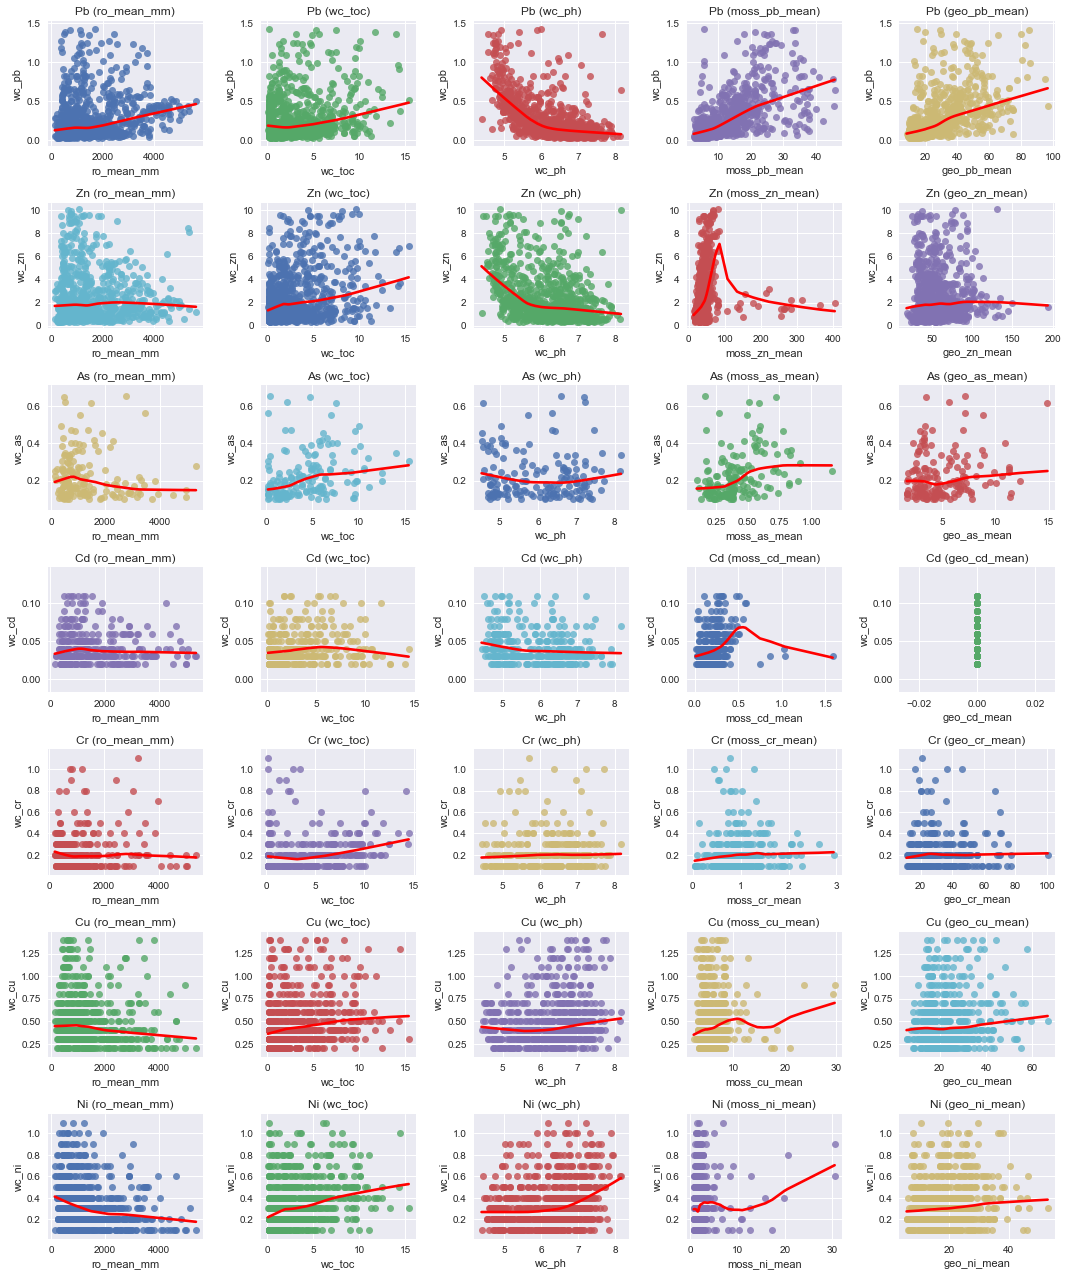

In [36]:
# All pars of interest
pars = ['pb', 'zn', 'as', 'cd', 'cr', 'cu', 'ni']

fig, axes = plt.subplots(nrows=8, ncols=5, figsize=(15,20))

# Loop over pars
for row, par in enumerate(pars):
    # Get data, clipping upper 5%
    df = get_par_data(data_df, par, clip=0.95)
        
    # Get explanatory vars
    exp_vars = ['ro_mean_mm', 'wc_toc', 'wc_ph', 'moss_%s_mean' % par, 
                'geo_%s_mean' % par]
    
    # Loop over exp_vars
    for col, exp_var in enumerate(exp_vars):
        # Plot
        with sn.plotting_context('notebook', font_scale=1.5):
            sn.regplot(x=exp_var, y='wc_%s' % par, data=df, ax=axes[row, col],
                       lowess=True, line_kws=dict(color='red'))
        axes[row, col].set_title('%s (%s)' % (par.capitalize(), exp_var))

# Fudge axis limits for last plot
for i in range(5):
    fig.delaxes(axes[7, i])    
plt.tight_layout()        

These plots are interesting, but they also highlight some issues with the data.

 * For Cd, Cr, Cu and Ni, there are obvious "quantisation" effects in the lake chemistry, either due to rounding errors or to most of the measurements being close to a (time variable?) limit of detection. This may not be a major problem for the regression analysis, but it does highlight the granularity of the data <br><br>
 
 * Patterns for Zn, As, Cd and Pb (all of which I expect to be influenced by LRTAP) are generally a bit clearer than for Cr, Ni and Cu <br><br>
 
 * The positive relationship between Pb and runoff is not replicated for any of the other metals, but Pb, Zn, As, Cu and Ni all have a roughly linear, positive relationship with TOC, as expected <br><br>
 
 * Zn and Pb both have a similarly shaped, exponential (or piece-wise linear?) negative relationship with pH (also as expected). Relationships for the other metals are less clear-cut: Ni, in particular, seems to behave differently to the others. **Can this be explained, or is it just noise?** <br><br>
 
 * The moss relationships are interesting: there is a clear, approximately linear correlation for Pb (although it's very noisy), and at low moss concentrations there are similar linear relationships for Zn and for Cd. However, there appear to be significant outliers in the moss data, which dramatically affect the lowess curves at higher moss concentrations. If these outliers are removed, the relationships between moss and water chemistry look pretty similar for Pb, Zn and Cd, as might be expected from my background reading (see plots below). **Can the high concentrations of Zn and Cd in the mosses at a small number of sites be explained?** Cr, Cu and Ni show less clear relationships and, again, the lowess curves appear to be strongly influenced by outliers in the moss measurements <br><br>
 
 * For the geochemistry data, there is a clear positive relationship for Pb, and also weaker but approximately linear relationships for Cu, Ni and (maybe) As
 
The plots below show the moss relationships for Pb, Zn and Cd, where the high moss concentrations for Zn and Cd have been removed. 

Int64Index([ 41,  42, 255, 562, 563, 564, 565, 577, 578, 587, 588, 589, 590,
            591, 592, 593, 594, 595, 935, 936],
           dtype='int64')
Int64Index([565, 587, 588, 589, 595], dtype='int64')


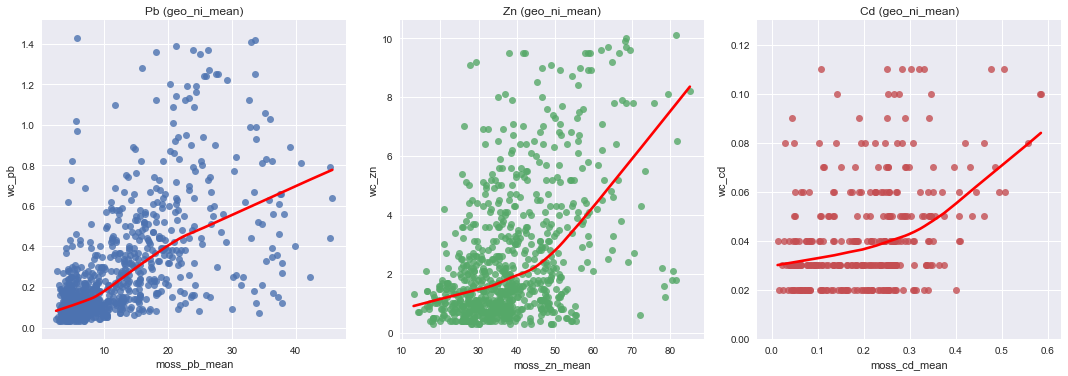

In [37]:
# All pars of interest
pars = ['pb', 'zn', 'cd']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

# Loop over pars
for idx, par in enumerate(pars):
    # Get data, clipping upper 5%
    df = get_par_data(data_df, par, clip=0.95)
    
    if par == 'zn':
        df2 = df.query('moss_zn_mean > 100')
        print df2.index
        df = df.query('moss_zn_mean < 100')
        
    if par == 'cd':
        df2 = df.query('moss_cd_mean > 0.6')
        print df2.index
        df = df.query('moss_cd_mean < 0.6')
       
    # Plot
    with sn.plotting_context('notebook', font_scale=1.5):
        sn.regplot(x='moss_%s_mean' % par, y='wc_%s' % par, data=df, 
                   ax=axes[0, idx],
                   lowess=True, line_kws=dict(color='red'))
    axes[0, idx].set_title('%s (%s)' % (par.capitalize(), exp_var))
    
# Fudge axis limits for last plot
for i in range(3):
    fig.delaxes(axes[1, i])    
plt.tight_layout()   

The code above also prints row IDs for the sites being removed as outliers. It is interesting to note that these "outlier" locations are similar for both Zn and Cd. I suspect there's something unusual going on at these sites i.e. there are some additional inputs of metals to the mosses that are not directly reflected in the water chemistry. It would be interesting to know whether they are all in the same geographic region. Let's find out:

In [38]:
# Get Zn > 100 (not clipping this time)
df = get_par_data(data_df, 'zn', clip=False)
df = df.query('moss_zn_mean > 100')
df = data_df.ix[df.index]
df['station_name'] = df['name']

# Map
nivapy.spatial.quickmap(df)

So the sites with very high concentrations of Zn and Cd in mosses are all located in the same area, roughly centred on Skare, to the SW of Hardangervidda. I assume there must be a substantial local source of these elements in this area, but it is interesting that the effects are reflected in the moss data, but not in the water chemistry. Perhaps this signal is present in the 1990 moss data (which I'm using here), but not in 1995 (which is when the water chemistry measurements were taken)? **Any other suggestions?**

### 8.2. Multiple linear regression

The initial exploration above suggests the following approach may give a reasonable linear regression model:

 * Ignore moss concentrations greater than 100 mg/kg for Zn and greater than 0.6 mg/kg for Cd as being due to local effects not accounted for in our data <br><br>
 
 * Standardise the data, as many of the variables are on very different scales <br><br>
 
 * Fit a multiple linear regression of the form:
 
 $$C_i^X = \beta_0^X + \beta_1^X M_i^X + \beta_2^X G_i^X + \beta_3^X \frac{P_i^X}{q_i} + \beta_4^X C_i^{TOC} + \beta_5^X C_i^{H^+}$$
 
 where $C_i^X$ is the concentration of metal $X$ in lake $i$; $M_i^X$ is the average concentration of $X$ in mosses in catchment $i$; $G_i^X$ is the average concentration of $X$ in river sediments in catchment $i$; $P_i^X$ are the point inputs in catchment $i$, which are divdied by an estimate of mean annual flow, $q_i$ to approximate concentrations; $C_i^{TOC}$ is the concentration of TOC in lake $i$; $C_i^{H^+}$ is the concentration of $H^+$ ions in lake $i$ (estimated as $10^{-pH}$) and the $\beta_j^X$ are the regression parameters for each metal <br><br>
 
Within the "full" model above, we can use "best subsets" regression to find the model with the lowest AIC from all possible combinations of the five explanatory variables. Note that, in general, I do not like the best subsets approach (regularized techniques such as lasso or ridge regression are usually better), but best subsets provides a useful comparison to the "full" model, which is what I'm really interested in here.

The sections below consider each metal in turn.

In [39]:
def best_subsets(df, resp_var, exp_vars):
    """ Performs all possible regressions involving exp_vars
        and returns the one with the lowest AIC.
    
    Args:
        df:       Dataframe
        resp_var: String. Response variable
        exp_vars: List of strings. Explanatory variables
    
    Returns:
        Results for best model.
    """
    import itertools
    import numpy as np
    import pandas as pd
    import statsmodels.api as sm

    # Dict to store BIC values
    aics = {}

    # Loop over all combinations
    for k in range(1, len(exp_vars)+1):
        for variables in itertools.combinations(exp_vars, k):
            preds = df[list(variables)]

            # Add constant
            preds = sm.add_constant(preds)

            # Compute OLS results
            res = sm.OLS(df[[resp_var,]], preds).fit()

            # Add result to dict
            aics[variables] = res.aic

    # Get the combination with lowest AIC
    best_vars = list(min(aics, key=aics.get))

    # Print regression results for these vars
    preds = df[list(best_vars)]

    # Add constant
    preds = sm.add_constant(preds)

    # Compute OLS results
    res = sm.OLS(df[[resp_var,]], preds).fit()

    print 'Regression results for the model with the lowest AIC:\n'
    print res.summary()
    
    return res

def mlr(data_df, par):
    """ Multiple linear regression for the specified parameter.
    """
    # Get data, clipping upper 5%
    df = get_par_data(data_df, par, clip=0.95)
    
    if par == 'zn':
        df = df[df['moss_zn_mean'] < 100]
    
    if par == 'cd':
        df = df[df['moss_cd_mean'] < 0.6]

    # Calc explan vars
    df['wc_hp'] = 10**(-1*df['wc_ph'])
    df['pt_q'] = df['pt_%s' % par] / df['q_mean']  

    # Standardise
    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)   
           
    # Best subsets 
    exp_vars = ['wc_toc', 'wc_hp', 'moss_%s_mean' % par, 'geo_%s_mean' % par, 'pt_q']    
    res = best_subsets(df, 'wc_%s' % par, exp_vars)
    
    # Plot best AIC model and residuals
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    
    axes[0].plot(df['wc_%s' % par], res.fittedvalues, 'ro')
    axes[0].plot(df['wc_%s' % par], df['wc_%s' % par], 'k-')
    axes[0].set_title('Modelled versus observed for %s\n(adjusted R2=%.2f)'
                      % (par.capitalize(), res.rsquared_adj), fontsize=18)
    axes[0].set_xlabel('Observed', fontsize=16)
    axes[0].set_ylabel('Modelled', fontsize=16)
    
    sn.distplot(res.resid, ax=axes[1])
    axes[1].set_title('Residuals for %s' % par.capitalize(), fontsize=18)
    axes[1].set_xlabel('Residual', fontsize=16)
    axes[1].set_ylabel('Normalised frequency', fontsize=16)
    
    plt.tight_layout()
    
    return (df, res)

#### 8.2.1. Pb

This seems to be a pretty good model. Point sources of Pb are not significant (as expected, due to limitations in the data) and, what's more, the sign of the coefficient for point sources does not make physical sense. The best model therefore ignores point inputs entirely, but all the other predictors (TOC, mosses, geochemistry and [H+]) are highly significant and have physically plausible model coefficents. Using the standardised variables, the final model is:

$$C_i^{Pb} = 0.20C_i^{TOC} + 0.47C_i^{H^+} + 0.23M_i^{Pb} + 0.17G_i^{Pb} + \epsilon$$

There is still a lot of scatter in the data but, overall, the model explains around 59% of the variance and the residuals appear to be roughly normally distributed with mean zero.

Looking at the standardised model coefficients, we can say (very coarsely) that [H+] is the "most important" variable, followed by mosses (i.e. deposition), TOC and, finally, geochemistry.

Regression results for the model with the lowest AIC:

                            OLS Regression Results                            
Dep. Variable:                  wc_pb   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     311.3
Date:                Mon, 04 Dec 2017   Prob (F-statistic):          5.01e-165
Time:                        18:09:23   Log-Likelihood:                -831.35
No. Observations:                 858   AIC:                             1673.
Df Residuals:                     853   BIC:                             1696.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

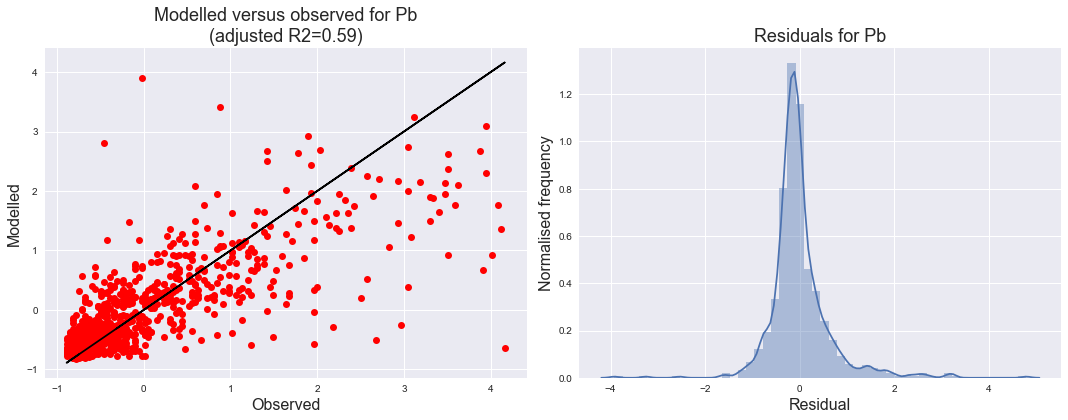

In [40]:
# MLR - Pb
df, res = mlr(data_df, 'pb')

#### 8.2.2. Zn

With the "outliers" in the moss data removed (see above) the results for Zn are similar to those for Pb:

$$C_i^{Zn} = 0.28C_i^{TOC} + 0.37C_i^{H^+} + 0.34M_i^{Zn} + 0.08G_i^{Zn} + \epsilon$$

The model is highly significant, and explains around 41% of the overall variance. The residuals are not normal, but they aren't too terrible either.

Regression results for the model with the lowest AIC:

                            OLS Regression Results                            
Dep. Variable:                  wc_zn   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     140.1
Date:                Mon, 04 Dec 2017   Prob (F-statistic):           2.01e-90
Time:                        18:09:24   Log-Likelihood:                -912.24
No. Observations:                 793   AIC:                             1834.
Df Residuals:                     788   BIC:                             1858.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

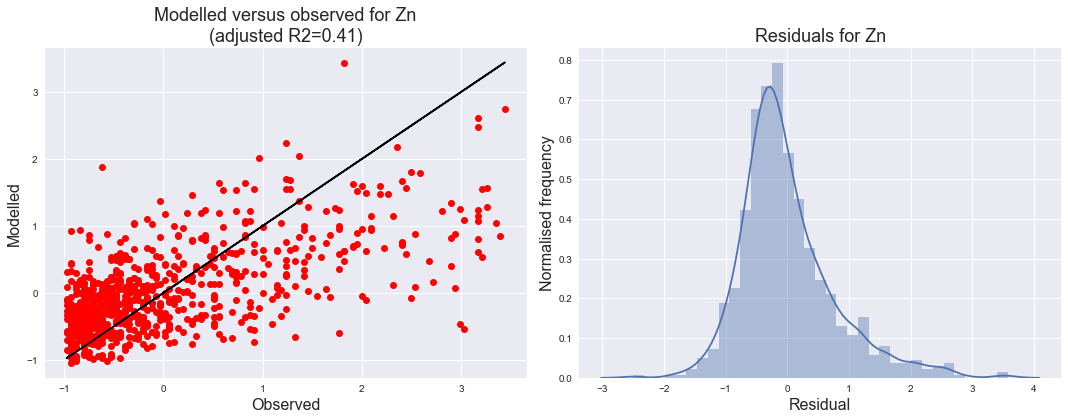

In [41]:
# MLR - Zn
df, res = mlr(data_df, 'zn')

#### 8.2.2. As (plots not shown)

This model explains only 18% of the variance:

$$C_i^{As} = 0.22C_i^{TOC} + 0.14C_i^{H^+} + 0.25M_i^{As} + 0.21G_i^{As} + \epsilon$$

The p-value for [H+] is 0.06; all others are significant at p < 0.05. Note however, that the residuals are distinctly non-normal.

#### 8.2.3. Cd (plots not shown)

The best model explains 15% of the variance and involves only mosses and [H+] (since Cd is not part of the geological dataset - see above):

$$C_i^{Cd} = 0.10C_i^{H^+} + 0.35M_i^{Cd} + \epsilon$$

Both variables are significant at p < 0.05 but, overall, the model looks very poor and the residuals are not normally distributed. 

#### 8.2.4. Cr (plots not shown)

I am not able to construct a meaningful linear model for the Cr data at all; the best model is the "null model" (i.e. the mean of the observations).

#### 8.2.5. Cu (plots not shown)

The best model for Cu explains only 8% of the overall variance and the residuals are strongly skewed. The model includes all five variables and all except "point sources" are significant at p < 0.05, but overall the model is very poor. The coefficient for [H+] is also negative, which seems implausible.

#### 8.2.5. Ni

The plots for Ni (shown below) illustrate the dangers of relying too much on summary statistics rather than visualistion: the summary information looks fairly promising, but the fit is basically useless. The plots for As, Cd, Cr and Cu (not shown) are similar.

The "best" model for Ni explains only 11% of the variance and four out of five explanatory variables are significant at p < 0.05 (the fifth, `pt_q`, has a p-value of 0.06). However, as with Cu, the coefficient for [H+] is unrealistic, the residuals are strongly skewed and overall fit is very poor when assessed visually.

Regression results for the model with the lowest AIC:

                            OLS Regression Results                            
Dep. Variable:                  wc_ni   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     19.62
Date:                Mon, 04 Dec 2017   Prob (F-statistic):           2.33e-18
Time:                        18:09:25   Log-Likelihood:                -990.86
No. Observations:                 731   AIC:                             1994.
Df Residuals:                     725   BIC:                             2021.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

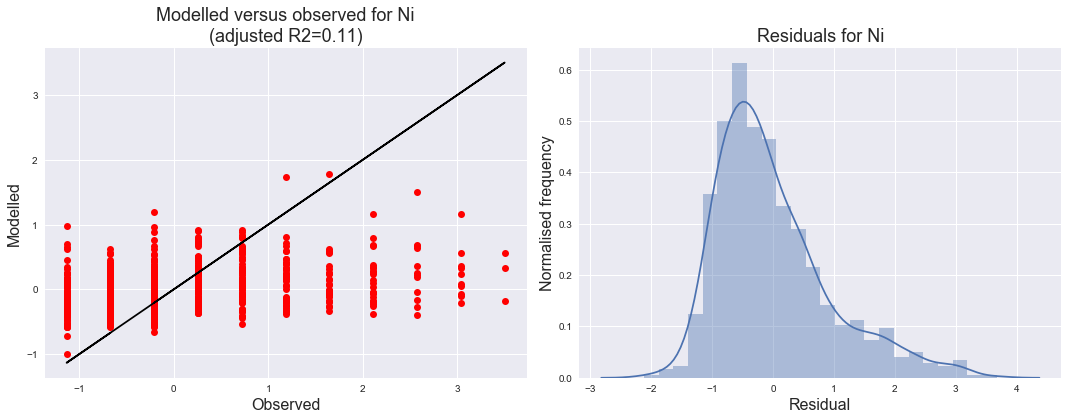

In [42]:
# MLR - Ni
df, res = mlr(data_df, 'ni')

#### 8.2.6. Summary of multiple linear regression

All the models tested above have high "statistical significance", but only two (Pb and Zn) look like they might actually be scientifically/practically useful. Part of the problem is that the concentrations of the other metals measured in lakes are typically very low (both in absolute terms and, more importantly, as a proportion of the LOD). The code below prints the LOD as a proportion of the mean measured lake concentration for each metal.

In [44]:
# All pars of interest
pars = ['pb', 'zn', 'as', 'cd', 'cr', 'cu', 'ni']

print 'LOD as a percentage of the mean:\n'

for par in pars:
    df = data_df[['wc_%s' % par]].copy()
    df = df[df['wc_%s' % par] > 0]
    print '%s: %.1f' % (par.capitalize(),
                        100*df['wc_%s' % par].min()/df['wc_%s' % par].mean())

LOD as a percentage of the mean:

Pb: 7.1
Zn: 8.9
As: 27.3
Cd: 38.0
Cr: 28.6
Cu: 29.4
Ni: 22.9


Note that for Pb and Zn - the two parameters with reasonable statistical models - the LOD represents 7% to 9% of the mean measured concentration, whereas for the other variables the mean concentration is much closer to the detection limit. This is also visible in the "quantisation"/rounding effect seen on plots for these variables (see above).

Overall, I suspect the level of precision in the water chemistry data for As, Cd, Cr, Cu and Ni is an important limiting factor in conducting a meaningful statistical analysis of these data. For Pb and Zn, the relationships identified are still very noisy, but they are consistent, as well as being both highly statistically significant and scientifically plausible.  

Based on the analysis so far, we could reasonably incorporate Pb and Zn into TEOTIL/NOPE, but I'm not sure what to do for As, Cd, Cr, Cu and Ni. Perhaps more recent data has lower detection limits?